Cell 1:
Import Libraries

In [16]:
#import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                             roc_auc_score, classification_report, confusion_matrix)
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import joblib
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap

Cell 2:
Load the dataset

In [17]:
# Load the dataset:
df = pd.read_csv(r'data.csv') # change to dataset location

# Fill the missing values:
df.fillna(method="ffill", inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_26052\533099284.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


Cell 3:
Extract the correct information from the category colum (hypen-seperated values from the first colum)

In [18]:
# Functions to extract unique files and records for each category:
def find_category(file_name):
    if "-" in file_name:
        return file_name.split("-")[0]
    else:
        return file_name

def find_category_name(file_name):
    if "-" in file_name:
        parts = file_name.split("-")
        return parts[1] if len(parts) > 1 else file_name
    else:
        return file_name

def extract_unique_file_id(file_name):
    return file_name.rsplit('-', 1)[0]

Cell 4:
Create new columns based on above information ( category, category_name, unique_file_id)
Summarise the dataset malware distribution

In [19]:
# Create new columns:
df["category"] = df["Category"].apply(find_category)
df["category_name"] = df["Category"].apply(find_category_name)
df["unique_file_id"] = df["Category"].apply(extract_unique_file_id)


# Compute unique file counts per malware family and create a summary DataFrame:
unique_counts = df.groupby('category_name')['unique_file_id'].nunique()
total_records = df['category_name'].value_counts()
df_category_summary = pd.DataFrame({
    'Total_Records': total_records,
    'Unique_File_Counts': unique_counts
})
df_category_summary['Percentage'] = (df_category_summary['Total_Records'] / len(df)) * 100
df_category_summary = df_category_summary.reset_index().rename(columns={'index': 'category_name'})
print("Category Summary:")
print(df_category_summary)
df_category_summary.to_csv("df_category_summary.csv", index=False)

Category Summary:
   category_name  Total_Records  Unique_File_Counts  Percentage
0   180solutions           2000                 200    3.413202
1            Ako           2000                 200    3.413202
2         Benign          29298                   1   50.000000
3            CWS           2000                 200    3.413202
4          Conti           1988                 200    3.392723
5         Emotet           1967                 200    3.356884
6          Gator           2200                 216    3.754522
7           Maze           1958                 176    3.341525
8           Pysa           1717                 192    2.930234
9        Reconyc           1570                 157    2.679364
10       Refroso           2000                 200    3.413202
11          Scar           2000                 200    3.413202
12         Shade           2128                 229    3.631647
13          TIBS           1410                 141    2.406308
14   Transponder      

Cell 5:
Preprocesses data (encoding labels, splitting into train/validation/test sets).
Trains multiple classifiers using GroupKFold for cross-validation, evaluates them, computes SHAP values, and saves results.

Feature columns defined: ['pslist.nproc', 'pslist.nppid', 'pslist.avg_threads', 'pslist.nprocs64bit', 'pslist.avg_handlers', 'dlllist.ndlls', 'dlllist.avg_dlls_per_proc', 'handles.nhandles', 'handles.avg_handles_per_proc', 'handles.nport', 'handles.nfile', 'handles.nevent', 'handles.ndesktop', 'handles.nkey', 'handles.nthread', 'handles.ndirectory', 'handles.nsemaphore', 'handles.ntimer', 'handles.nsection', 'handles.nmutant', 'ldrmodules.not_in_load', 'ldrmodules.not_in_init', 'ldrmodules.not_in_mem', 'ldrmodules.not_in_load_avg', 'ldrmodules.not_in_init_avg', 'ldrmodules.not_in_mem_avg', 'malfind.ninjections', 'malfind.commitCharge', 'malfind.protection', 'malfind.uniqueInjections', 'psxview.not_in_pslist', 'psxview.not_in_eprocess_pool', 'psxview.not_in_ethread_pool', 'psxview.not_in_pspcid_list', 'psxview.not_in_csrss_handles', 'psxview.not_in_session', 'psxview.not_in_deskthrd', 'psxview.not_in_pslist_false_avg', 'psxview.not_in_eprocess_pool_false_avg', 'psxview.not_in_ethread_po

100%|===================| 280424/280448 [25:49<00:00]        

SHAP explanation failed for RandomForest: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.281708, while the model output was 0.270539. If this difference is acceptable you can set check_additivity=False to disable this check.

Validation Set Classification Report for RandomForest:
              precision    recall  f1-score   support

180solutions     0.0000    0.0000    0.0000        90
         Ako     0.1538    0.1333    0.1429        60
      Benign     1.0000    1.0000    1.0000      1475
         CWS     0.0000    0.0000    0.0000        50
       Conti     0.0000    0.0000    0.0000       108
      Emotet     0.1810    0.2625    0.2143        80
       Gator     0.6232    0.3707    0.4649       116
        Maze     0.1722    0.2889    

C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:

              precision    recall  f1-score   support

180solutions     0.3708    0.0600    0.1033       550
         Ako     0.2794    0.1407    0.1872       540
      Benign     0.9994    0.9999    0.9997      8792
         CWS     0.5238    0.0493    0.0900       670
       Conti     0.6364    0.0110    0.0215       639
      Emotet     0.1457    0.2664    0.1884       488
       Gator     0.7258    0.4477    0.5538       822
        Maze     0.2222    0.3655    0.2764       580
        Pysa     0.6964    0.0724    0.1311       539
     Reconyc     0.5882    0.0175    0.0341       570
     Refroso     0.5163    0.3654    0.4279       520
        Scar     0.1625    0.5033    0.2456       600
       Shade     0.2013    0.1558    0.1757       616
        TIBS     0.7707    0.2881    0.4194       420
 Transponder     0.1517    0.4298    0.2243       570
        Zeus     0.2251    0.5131    0.3129       612

    accuracy                         0.6257     17528
   macro avg     0.4510   

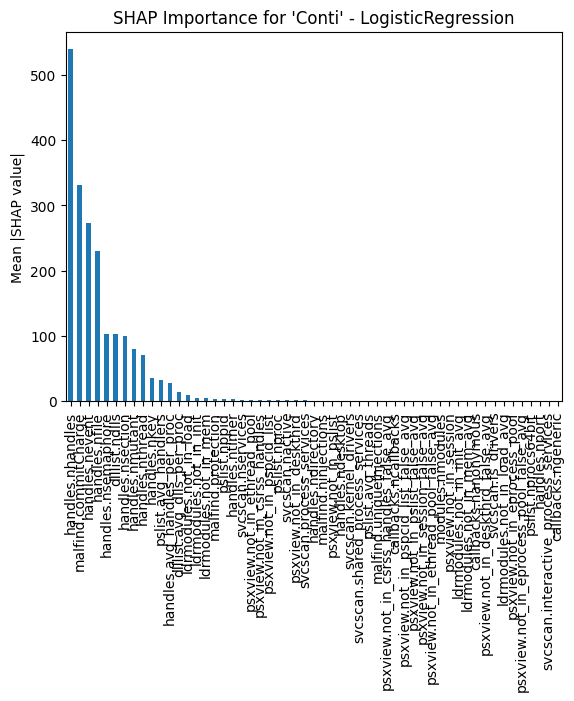


Validation Set Classification Report for LogisticRegression:
              precision    recall  f1-score   support

180solutions     0.1250    0.0222    0.0377        90
         Ako     0.0000    0.0000    0.0000        60
      Benign     0.9980    1.0000    0.9990      1475
         CWS     0.0000    0.0000    0.0000        50
       Conti     0.1778    0.0741    0.1046       108
      Emotet     0.0914    0.2125    0.1278        80
       Gator     0.4505    0.3534    0.3961       116
        Maze     0.1223    0.1889    0.1485        90
        Pysa     0.5714    0.0825    0.1441        97
     Reconyc     0.4286    0.0429    0.0779        70
     Refroso     0.4043    0.4750    0.4368       160
        Scar     0.1364    0.1200    0.1277       100
       Shade     0.1985    0.3714    0.2587        70
        TIBS     0.2375    0.3167    0.2714        60
 Transponder     0.0986    0.1909    0.1300       110
        Zeus     0.1349    0.1278    0.1313       133

    accuracy      

C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:


SHAP Feature Importance for 'Conti' - DecisionTree:
dlllist.avg_dlls_per_proc                 0.017011
svcscan.nservices                         0.016160
malfind.uniqueInjections                  0.004490
ldrmodules.not_in_init_avg                0.003363
malfind.commitCharge                      0.000115
ldrmodules.not_in_mem_avg                 0.000100
psxview.not_in_deskthrd_false_avg         0.000084
callbacks.ncallbacks                      0.000050
psxview.not_in_pslist_false_avg           0.000000
psxview.not_in_deskthrd                   0.000000
psxview.not_in_pspcid_list                0.000000
psxview.not_in_session                    0.000000
psxview.not_in_csrss_handles              0.000000
psxview.not_in_ethread_pool_false_avg     0.000000
psxview.not_in_ethread_pool               0.000000
psxview.not_in_eprocess_pool              0.000000
psxview.not_in_eprocess_pool_false_avg    0.000000
psxview.not_in_session_false_avg          0.000000
psxview.not_in_pspcid_list_fa

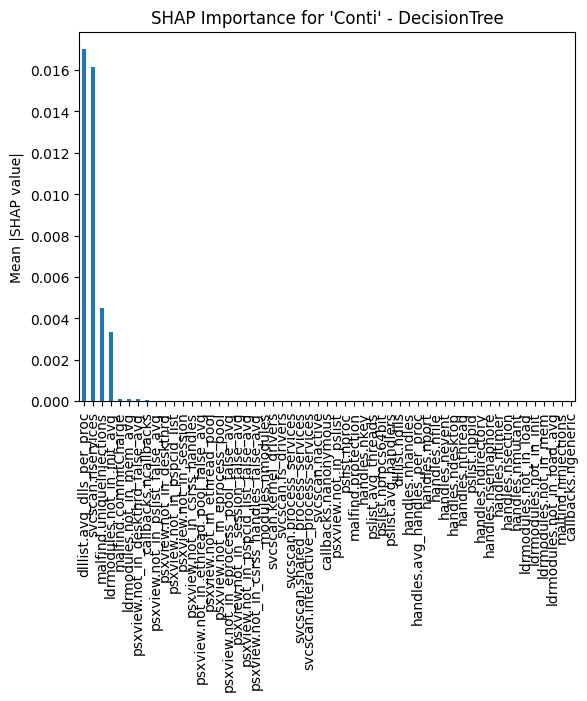


Validation Set Classification Report for DecisionTree:
              precision    recall  f1-score   support

180solutions     0.0000    0.0000    0.0000        90
         Ako     0.0000    0.0000    0.0000        60
      Benign     1.0000    0.9953    0.9976      1475
         CWS     0.0000    0.0000    0.0000        50
       Conti     0.0000    0.0000    0.0000       108
      Emotet     0.0724    1.0000    0.1350        80
       Gator     0.5057    0.3793    0.4335       116
        Maze     0.0000    0.0000    0.0000        90
        Pysa     0.4545    0.0515    0.0926        97
     Reconyc     0.0000    0.0000    0.0000        70
     Refroso     0.9800    0.3063    0.4667       160
        Scar     0.0000    0.0000    0.0000       100
       Shade     0.0000    0.0000    0.0000        70
        TIBS     0.3571    0.1667    0.2273        60
 Transponder     0.2281    0.2364    0.2321       110
        Zeus     0.0000    0.0000    0.0000       133

    accuracy            

C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:

              precision    recall  f1-score   support

180solutions     0.0000    0.0000    0.0000       550
         Ako     0.0000    0.0000    0.0000       540
      Benign     0.9997    0.9959    0.9978      8792
         CWS     0.8000    0.0179    0.0350       670
       Conti     0.0000    0.0000    0.0000       639
      Emotet     0.0661    0.9344    0.1234       488
       Gator     0.5337    0.4623    0.4954       822
        Maze     0.0000    0.0000    0.0000       580
        Pysa     0.6230    0.0705    0.1267       539
     Reconyc     0.0000    0.0000    0.0000       570
     Refroso     0.6495    0.3635    0.4661       520
        Scar     0.0000    0.0000    0.0000       600
       Shade     0.0000    0.0000    0.0000       616
        TIBS     0.7586    0.2619    0.3894       420
 Transponder     0.1713    0.1930    0.1815       570
        Zeus     0.0000    0.0000    0.0000       612

    accuracy                         0.5734     17528
   macro avg     0.2876   

In [ ]:
#model training and preprocessing

# ---------------------------------------------------------PREPROCESSING & ENCODING--------------------------------------------------------
meta_cols = ['Category', 'category_name', 'unique_file_id']
df_meta = df[meta_cols].copy()

le_class = LabelEncoder()
le_category = LabelEncoder()
le_catname = LabelEncoder()

df['Class_encoded'] = le_class.fit_transform(df['Class'])
df['category_encoded'] = le_category.fit_transform(df['category'])
df['category_name_encoded'] = le_catname.fit_transform(df['category_name'])

df['group_id'] = df.apply(lambda row: row['unique_file_id'] 
                                    if row['Class'] != 'Benign' 
                                    else f"benign_{row.name}", axis=1)

# Drop columns used for meta or non-numeric:
features = df.drop(columns=[
    'Category', 'Class', 'category', 'category_name',
    'Class_encoded', 'category_encoded', 'category_name_encoded',
    'unique_file_id', 'group_id'
])
target = df['category_name_encoded']


# ----------------------------------------------------------SPLITTING DATA--------------------------------------------------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.35, random_state=42)
train_idx, temp_idx = next(gss.split(df, groups=df['group_id']))
train_df = df.iloc[train_idx]
temp_df = df.iloc[temp_idx]

gss_temp = GroupShuffleSplit(n_splits=1, test_size=0.857, random_state=42)
val_idx, test_idx = next(gss_temp.split(temp_df, groups=temp_df['group_id']))
validation_df = temp_df.iloc[val_idx]
test_df = temp_df.iloc[test_idx]

def get_features_and_target(sub_df):
    X = sub_df.drop(columns=[
        'Category', 'Class', 'category', 'category_name', 
        'Class_encoded', 'category_encoded', 'category_name_encoded',
        'unique_file_id', 'group_id'
    ])
    y = sub_df['category_name_encoded']
    return X, y

X_train, y_train = get_features_and_target(train_df)
X_val, y_val = get_features_and_target(validation_df)
X_test, y_test = get_features_and_target(test_df)
feature_cols = X_train.columns.tolist()  # Add this line to define feature_cols
print("Feature columns defined:", feature_cols)  # Optional: verify the columns

meta_val = validation_df[meta_cols].copy()
meta_test = test_df[meta_cols].copy()

total = len(X_train) + len(X_val) + len(X_test)
print("Total records:", total)
print("Train:", len(X_train), f"({round((len(X_train)/total)*100,2)}%)")
print("Test:", len(X_test), f"({round((len(X_test)/total)*100,2)}%)")
print("Validation:", len(X_val), f"({round((len(X_val)/total)*100,2)}%)")


# -------------------------------------------------------CLASSIFIERS & CONFIGURATION--------------------------------------------------
rf_classifier = RandomForestClassifier(
    n_estimators=50, max_depth=5, min_samples_split=4, 
    min_samples_leaf=2, random_state=42
)
knn_classifier = KNeighborsClassifier(n_neighbors=7, weights='distance')
logistic_classifier = LogisticRegression(
    penalty='l2', C=0.5, solver='liblinear', max_iter=1000, random_state=42
)
tree_classifier = DecisionTreeClassifier(
    max_depth=5, min_samples_split=4, min_samples_leaf=2, random_state=42
)
svm_classifier = SVC(
    kernel='rbf', C=0.5, gamma='scale', probability=True, random_state=42
)

# Classifier dictionary (model, scale_required):
classifiers = {
    'RandomForest': (rf_classifier, False),
   # 'KNN': (knn_classifier, True),
    'LogisticRegression': (logistic_classifier, True),
    'DecisionTree': (tree_classifier, False),
    #'SVM': (svm_classifier, True)
}

# Hyperparameter grids:
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 75],
        'max_depth': [3, 5, 7],
        'min_samples_split': [4, 6],
        'min_samples_leaf': [2, 3]
    },
    'KNN': {
        'n_neighbors': [7, 9, 11]
    },
    'LogisticRegression': {
        'C': [0.1, 0.5, 1]
    },
    'DecisionTree': {
        'max_depth': [3, 5],
        'min_samples_split': [6, 8],
        'min_samples_leaf': [2, 3]
    },
    'SVM': {
        'C': [0.1, 0.5, 1],
        'kernel': ['rbf']
    }
}

results_dict = {}
shap_values_dict = {}
train_groups = train_df['group_id']

# Encoded value for "Conti":
conti_label = "Conti"
conti_encoded = le_catname.transform([conti_label])[0]

# Lists to collect evaluation metrics and SHAP features:
metrics_list = []
shap_features_list = []

# -------------------------------------------------------TRAINING, EVALUATION & SHAP--------------------------------------------------
for clf_name, (clf_obj, scale_required) in classifiers.items():
    print(f"\nTraining and evaluating {clf_name}...")

    # Build pipeline:
    if scale_required:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clf_obj)
        ])
        # GridSearchCV for relevant classifier:
        if clf_name in param_grids:
            grid = {f'clf__{param}': values for param, values in param_grids[clf_name].items()}
            grid_search = GridSearchCV(
                pipeline, grid, cv=GroupKFold(n_splits=5),
                scoring='accuracy', n_jobs=-1
            )
            grid_search.fit(X_train, y_train, groups=train_groups)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
        else:
            best_model = pipeline.fit(X_train, y_train)
    else:
        # No scaling:
        if clf_name in param_grids:
            grid_search = GridSearchCV(
                clf_obj, param_grids[clf_name], cv=GroupKFold(n_splits=5),
                scoring='accuracy', n_jobs=-1
            )
            grid_search.fit(X_train, y_train, groups=train_groups)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
            
        else:
            best_model = clf_obj.fit(X_train, y_train)
    joblib.dump(best_model, f"{clf_name}_AA_model.pkl")
    print(f"Saved model to {clf_name}_AA_model.pkl")


# -------------------------------------------------------Predictions & Metrics--------------------------------------------------------
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)
    
    y_val_pred_labels = le_catname.inverse_transform(y_val_pred)
    y_val_labels = le_catname.inverse_transform(y_val)
    y_test_pred_labels = le_catname.inverse_transform(y_test_pred)
    y_test_labels = le_catname.inverse_transform(y_test)
    
    # Classification report for each class:
    report_dict = classification_report(y_test_labels, y_test_pred_labels, output_dict=True)
    for class_label, scores in report_dict.items():
        if class_label not in ["accuracy", "macro avg", "weighted avg"]:
            metrics_list.append({
                'Classifier': clf_name,
                'Class': class_label,
                'Precision': scores.get('precision', None),
                'Recall': scores.get('recall', None),
                'F1-score': scores.get('f1-score', None),
                'Support': scores.get('support', None)
            })
    
# -------------------------------------------------------SHAP Feature Importance for "Conti"------------------------------------------
    try:
        # If model is wrapped in pipeline, extract the final estimator
        if scale_required:
            model_for_shap = best_model.named_steps['clf']
        else:
            model_for_shap = best_model
        
        # Create a generic SHAP explainer:
        explainer = shap.Explainer(model_for_shap, X_train, feature_names=X_train.columns)
        shap_values = explainer(X_test)
        
        # Store the SHAP values for potential future plotting:
        shap_values_dict[clf_name] = shap_values

        # If multi-class, isolate the "Conti" class:
        if len(shap_values.values.shape) == 3:
            # shape: (n_samples, n_features, n_classes):
            conti_shap = shap_values.values[:, :, conti_encoded]
            mean_shap = np.abs(conti_shap).mean(axis=0)
        else:
            mean_shap = np.abs(shap_values.values).mean(axis=0)
        
        shap_importance = pd.Series(mean_shap, index=X_test.columns).sort_values(ascending=False)
        
        print(f"\nSHAP Feature Importance for '{conti_label}' - {clf_name}:")
        print(shap_importance)
        

        # Plot a bar chart of all features:
        feature_importance = shap_importance
        feature_importance.plot(kind='bar', title=f"SHAP Importance for '{conti_label}' - {clf_name}")
        plt.ylabel('Mean |SHAP value|')
        plt.show()
        
        # Collect all SHAP features for Excel output:
        for feature, shap_val in feature_importance.items():
            shap_features_list.append({
                'Classifier': clf_name, 
                'Feature': feature, 
                'SHAP Importance': shap_val
            })
    
    except Exception as e:
        print(f"SHAP explanation failed for {clf_name}: {e}")
    

# -----------------------------------------------------------Save Test Results--------------------------------------------------------
    if hasattr(best_model, "predict_proba"):
        test_probs = best_model.predict_proba(X_test)
        predicted_probabilities = [round(prob[label] * 100, 2)
                                   for prob, label in zip(test_probs, y_test_pred)]
    else:
        predicted_probabilities = [None] * len(y_test)
    
    results_test_clf = X_test.copy()
    results_test_clf['Actual_Class'] = y_test_labels
    results_test_clf['Predicted_Class'] = y_test_pred_labels
    results_test_clf['Correct'] = results_test_clf['Actual_Class'] == results_test_clf['Predicted_Class']
    results_test_clf['Prediction_Probability'] = predicted_probabilities
    results_test_clf = results_test_clf.merge(meta_test, left_index=True, right_index=True)
    
    csv_filename = f"{clf_name}_Malware_Type_Test_Results.csv"
    results_test_clf.to_csv(csv_filename, index=False)
    
    # Print Validation and Test Reports:
    print(f"\nValidation Set Classification Report for {clf_name}:")
    print(classification_report(y_val_labels, y_val_pred_labels, digits=4))
    print(f"\nTest Set Classification Report for {clf_name}:")
    print(classification_report(y_test_labels, y_test_pred_labels, digits=4))
    
    results_dict[clf_name] = results_test_clf

# -----------------------------------------------------------SAVE RESULTS TO EXCEL----------------------------------------------------
metrics_df = pd.DataFrame(metrics_list)
shap_features_df = pd.DataFrame(shap_features_list)

with pd.ExcelWriter("Classifier_Results.xlsx") as writer:
    metrics_df.to_excel(writer, sheet_name="Metrics", index=False)
    shap_features_df.to_excel(writer, sheet_name="SHAP_Features", index=False)
    
print("\nCombined classification metrics and SHAP feature importances saved to 'Classifier_Results.xlsx'.")

# Save the datasets:
train_df.to_csv("Train_Dataset_Malware_Type.csv", index=False)
validation_df.to_csv("Validation_Dataset_Malware_Type.csv", index=False)
test_df.to_csv("Test_Dataset_Malware_Type.csv", index=False)

Cell 6:
SHAP Summary Plot from above results


Generating SHAP summary plot for LogisticRegression...


C:\Users\MSI\AppData\Local\Temp\ipykernel_26052\4109282783.py:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_array, X_test_np, feature_names=feature_names, show=False)


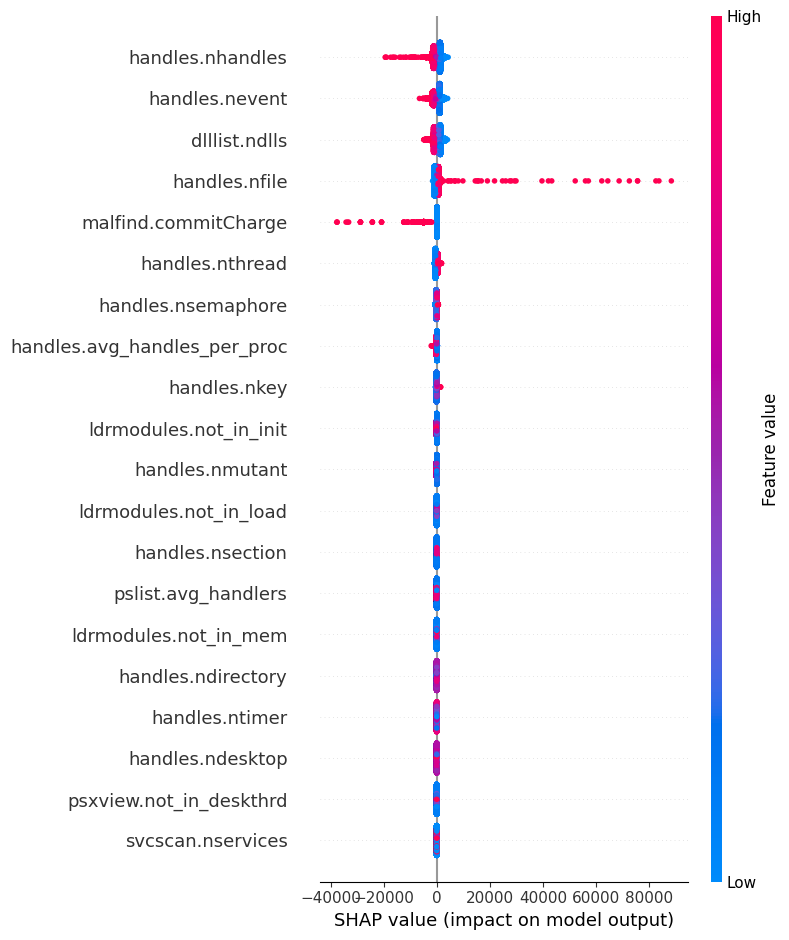

In [ ]:
#example of SHAP Summary Plots
#list_of_classifiers = ["RandomForest", "LogisticRegression", "DecisionTree"]
#iterate over above list to see all results eg:
#for classifier in list_of_classifiers:


# Choose a classifier for SHAP visualization, change this for different models:
clf_to_plot = "LogisticRegression"

if clf_to_plot in shap_values_dict:
    shap_values = shap_values_dict[clf_to_plot]

    print(f"\nGenerating SHAP summary plot for {clf_to_plot}...")

    # Convert SHAP Explanation object to NumPy format:
    if isinstance(shap_values, shap.Explanation):
        shap_values_array = shap_values.values
        feature_names = shap_values.feature_names
    else:
        shap_values_array = shap_values
        feature_names = X_test.columns.tolist()

    # Ensure SHAP values are 2D for summary plot:
    if shap_values_array.ndim == 3:
        shap_values_array = shap_values_array[:, :, 0]

    # Convert X_test to NumPy for SHAP compatibility:
    X_test_np = X_test.to_numpy()

    # Add Title to the Plot:
    plt.figure(figsize=(12, 8))
    plt.title(f"SHAP Summary Plot - {clf_to_plot} Model", fontsize=14, fontweight="bold")
    shap.summary_plot(shap_values_array, X_test_np, feature_names=feature_names, show=False)
    plt.show()

else:
    print(f"SHAP values not found for {clf_to_plot}. Ensure training completed successfully.")

Cell 7:
Adversarial Sample Generation (FGSM)
Generates samples for use in attack simulation

In [44]:
import pandas as pd
import numpy as np
import joblib
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier

# Declare the classifiers to use in the attack simulation
classifiers = ['LogisticRegression', 'DecisionTree', 'RandomForest']

# Load pre-trained models
trained_models = {clf: joblib.load(f"{clf}_AA_model.pkl") for clf in classifiers}

# Adversarial Sample Generation - use random seed for reproducibility
np.random.seed(42)

# Select 100 random Conti samples from test set
conti_encoded = le_catname.transform(['Conti'])[0]
conti_indices = test_df[test_df['category_name_encoded'] == conti_encoded].index
if len(conti_indices) < 100:
    print(f"Warning: Only {len(conti_indices)} Conti samples available. Using all available samples.")
    selected_indices = conti_indices
else:
    selected_indices = np.random.choice(conti_indices, 100, replace=False)

# Get the selected samples
X_test_conti = X_test.loc[selected_indices]
y_test_conti = test_df.loc[selected_indices, 'category_name_encoded']

# Keep track of the original samples for analysis
original_category = test_df.loc[selected_indices, 'Category']
original_class = test_df.loc[selected_indices, 'Class']
original_category_type = test_df.loc[selected_indices, 'category']
original_category_name = test_df.loc[selected_indices, 'category_name']

# Save original samples to CSV
original_samples_df = X_test_conti.copy()
original_samples_df['Category'] = original_category.values
original_samples_df['Class'] = original_class.values
original_samples_df['category'] = original_category_type.values
original_samples_df['category_name'] = original_category_name.values
original_samples_df.to_csv("original_fgsm_samples.csv", index=False)

# Declare the features not to modify based on the critical feature list
features_not_to_modify = [
    "malfind.uniqueInjections", "malfind.protection", "malfind.commitCharge",
    "pslist.avg_threads", "malfind.ninjections", "pslist.avg_handlers",
    "psxview.not_in_deskthrd_false_avg", "pslist.nppid", "pslist.nproc",
    "svcscan.kernel_drivers", "psxview.not_in_eprocess_pool_false_avg",
    "callbacks.ngeneric", "callbacks.nanonymous", "pslist.nprocs64bit",
    "psxview.not_in_eprocess_pool", "psxview.not_in_ethread_pool",
    "psxview.not_in_pslist", "psxview.not_in_pspcid_list", "psxview.not_in_session",
    "psxview.not_in_pspcid_list_false_avg", "callbacks.ncallbacks",
    "psxview.not_in_session_false_avg", "psxview.not_in_ethread_pool_false_avg",
    "psxview.not_in_deskthrd", "psxview.not_in_csrss_handles_false_avg",
    "psxview.not_in_pslist_false_avg", "psxview.not_in_csrss_handles",
    "pslist.avg_handlers", "psxview.not_in_deskthrd_false_avg", "pslist.nppid"
]

# Validate that all features_not_to_modify exist in X_test.columns
missing_features = [feat for feat in features_not_to_modify if feat not in X_test.columns]
if missing_features:
    print(f"Warning: The following features not to modify are missing in X_test: {missing_features}")

indices_not_to_modify = [X_test.columns.get_loc(feat) for feat in features_not_to_modify if feat in X_test.columns]

# Epsilon values to test
epsilon_values = [0.0, 0.05, 0.1, 0.15, 0.2]

# Specify the source model for FGSM attack
source_model = 'LogisticRegression'

# Perform FGSM attack using the source model
scaler = trained_models[source_model].named_steps.get('scaler', None)
model_clf = trained_models[source_model].named_steps['clf'] if scaler else trained_models[source_model]

# Scale the Conti samples if required
X_test_conti_scaled = scaler.transform(X_test_conti) if scaler else X_test_conti.values

# Create SklearnClassifier for ART
classifier = SklearnClassifier(model=model_clf)

# Target 'Benign' for adversarial attack
benign_encoded = le_catname.transform(['Benign'])[0]
y_target = np.full(len(X_test_conti_scaled), benign_encoded)

# Generate and save adversarial samples for each epsilon
adversarial_samples = {}
for eps in epsilon_values:
    print(f"Generating adversarial samples with {source_model} model, epsilon={eps}")
    
    # Define FGSM attack
    fgsm = FastGradientMethod(estimator=classifier, eps=eps, targeted=True)
    
    if eps == 0.0:
        # No perturbation for baseline comparison
        X_test_adv_raw = X_test_conti.values
    else:
        # Generate adversarial samples
        X_test_adv_scaled = fgsm.generate(X_test_conti_scaled, y=y_target)
        
        # Create a copy of the adversarial scaled data
        X_test_adv_final = X_test_adv_scaled.copy()
        
        # Copy protected features in scaled space
        X_test_adv_final[:, indices_not_to_modify] = X_test_conti_scaled[:, indices_not_to_modify]
        
        # Inverse transform to original space if scaled
        X_test_adv_raw = scaler.inverse_transform(X_test_adv_final) if scaler else X_test_adv_final
    
    # Convert to DataFrame
    X_test_adv_df = pd.DataFrame(X_test_adv_raw, columns=feature_cols)
    
    # Overwrite protected features with original unscaled values
    X_test_adv_df.iloc[:, indices_not_to_modify] = X_test_conti.iloc[:, indices_not_to_modify].values
    
    # Add metadata
    X_test_adv_df['Category'] = original_category.values
    X_test_adv_df['Class'] = original_class.values
    
    # Validation check to ensure protected features remain unchanged
    original_features = X_test_conti.iloc[:, indices_not_to_modify].values
    modified_features = X_test_adv_df.iloc[:, indices_not_to_modify].values
    difference = np.abs(original_features - modified_features)
    max_diff = np.max(difference)
    print(f"Maximum difference in protected features: {max_diff}")
    
    # Define column order
    columns_order = ['Category'] + feature_cols + ['Class']
    X_test_adv_df = X_test_adv_df[columns_order]
    
    # Save adversarial samples
    csv_filename = f"modified_fgsm_samples_{source_model}_eps_{eps}.csv"
    X_test_adv_df.to_csv(csv_filename, index=False)
    print(f"Saved adversarial samples to '{csv_filename}'")
    
    # Store adversarial samples for later use
    adversarial_samples[eps] = X_test_adv_df

Generating adversarial samples with LogisticRegression model, epsilon=0.0
Maximum difference in protected features: 0.0
Saved adversarial samples to 'modified_fgsm_samples_LogisticRegression_eps_0.0.csv'
Generating adversarial samples with LogisticRegression model, epsilon=0.05
Maximum difference in protected features: 0.0
Saved adversarial samples to 'modified_fgsm_samples_LogisticRegression_eps_0.05.csv'
Generating adversarial samples with LogisticRegression model, epsilon=0.1
Maximum difference in protected features: 0.0
Saved adversarial samples to 'modified_fgsm_samples_LogisticRegression_eps_0.1.csv'
Generating adversarial samples with LogisticRegression model, epsilon=0.15
Maximum difference in protected features: 0.0
Saved adversarial samples to 'modified_fgsm_samples_LogisticRegression_eps_0.15.csv'
Generating adversarial samples with LogisticRegression model, epsilon=0.2
Maximum difference in protected features: 0.0
Saved adversarial samples to 'modified_fgsm_samples_Logistic

C:\Users\MSI\AppData\Local\Temp\ipykernel_26052\733518372.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 9.43902439 10.2195122  10.28571429  9.77777778  9.525       9.65
 10.10810811  9.55       10.70454545  9.71428571 11.35897436  9.56097561
 10.41463415 10.75       10.34375    10.69230769 10.79411765 12.25
  9.73170732 11.68571429 10.04878049 10.18918919 10.28571429  9.41463415
  9.55        9.58536585 11.30769231  9.32432432 10.91176471  9.27906977
 10.71428571  9.825      11.41025641  9.34090909 10.08333333 10.76923077
 10.38095238  9.30232558 10.37142857  9.27272727  9.56818182  9.775
  9.09090909 10.73809524  9.80487805 10.08108108  9.46341463  9.5
  9.59090909 10.64102564  9.825      11.41463415  9.76923077  9.39534884
  9.18181818  9.68292683  9.91891892 10.25714286  9.26829268 10.69047619
 10.07894737  9.27272727 10.74358974 10.07894737  9.24390244  9.8974359
  9.45238095 10.18421053  9.3255814  1

SHAP Value Comparison
- Compares the SHAP values of the adversarial samples VS the original Conti samples, same features should be important across models.


SHAP Value Comparison for epsilon=0.0 (Sorted by Mean SHAP Original):
                               Feature  Mean_SHAP_Original  Mean_SHAP_Adversarial_eps_0.0
                         handles.nfile          721.906403                     721.906403
                      handles.nhandles          640.734905                     640.734905
                  malfind.commitCharge          310.722960                     310.722960
                        handles.nevent          261.891672                     261.891672
                    handles.nsemaphore          105.695306                     105.695306
                         dlllist.ndlls          101.951634                     101.951634
                      handles.nsection           96.542284                      96.542284
                       handles.nmutant           79.869171                      79.869171
                       handles.nthread           67.295428                      67.295428
                   pslist.avg

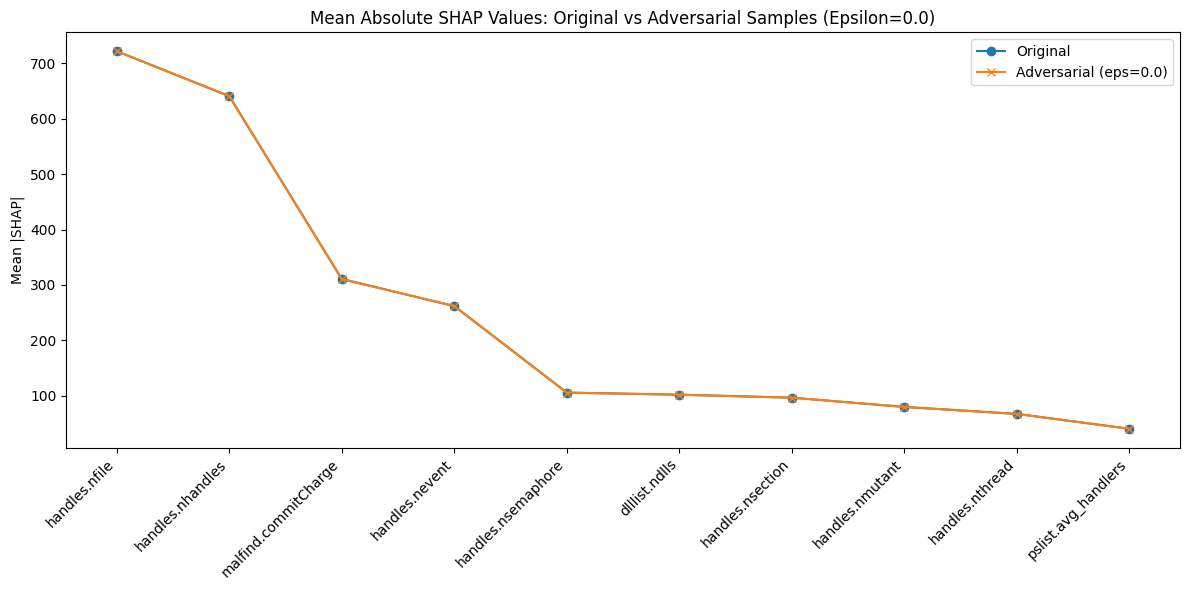


SHAP Value Comparison for epsilon=0.05 (Sorted by Mean SHAP Original):
                               Feature  Mean_SHAP_Original  Mean_SHAP_Adversarial_eps_0.05
                         handles.nfile          721.906403                      915.114328
                      handles.nhandles          640.734905                      586.471087
                  malfind.commitCharge          310.722960                      310.722960
                        handles.nevent          261.891672                      246.813549
                    handles.nsemaphore          105.695306                      111.961981
                         dlllist.ndlls          101.951634                       96.024567
                      handles.nsection           96.542284                       90.501787
                       handles.nmutant           79.869171                       75.352684
                       handles.nthread           67.295428                       63.485415
                  

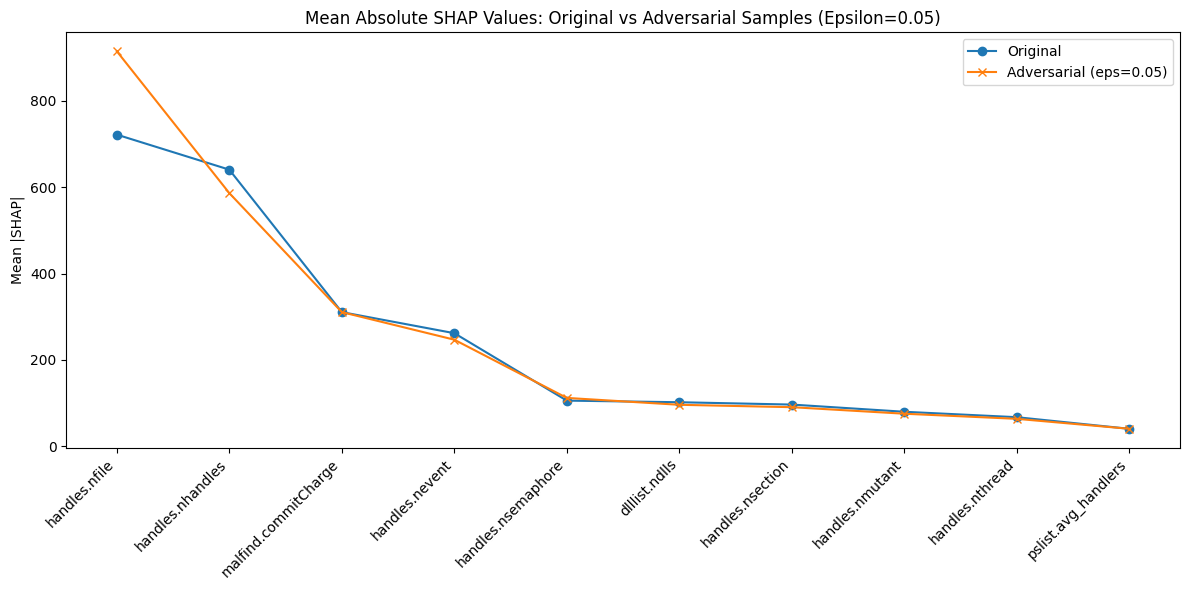


SHAP Value Comparison for epsilon=0.1 (Sorted by Mean SHAP Original):
                               Feature  Mean_SHAP_Original  Mean_SHAP_Adversarial_eps_0.1
                         handles.nfile          721.906403                    1109.082633
                      handles.nhandles          640.734905                     532.207094
                  malfind.commitCharge          310.722960                     310.722960
                        handles.nevent          261.891672                     231.735422
                    handles.nsemaphore          105.695306                     118.228657
                         dlllist.ndlls          101.951634                      90.097500
                      handles.nsection           96.542284                      84.461294
                       handles.nmutant           79.869171                      70.836185
                       handles.nthread           67.295428                      59.675403
                   pslist.avg

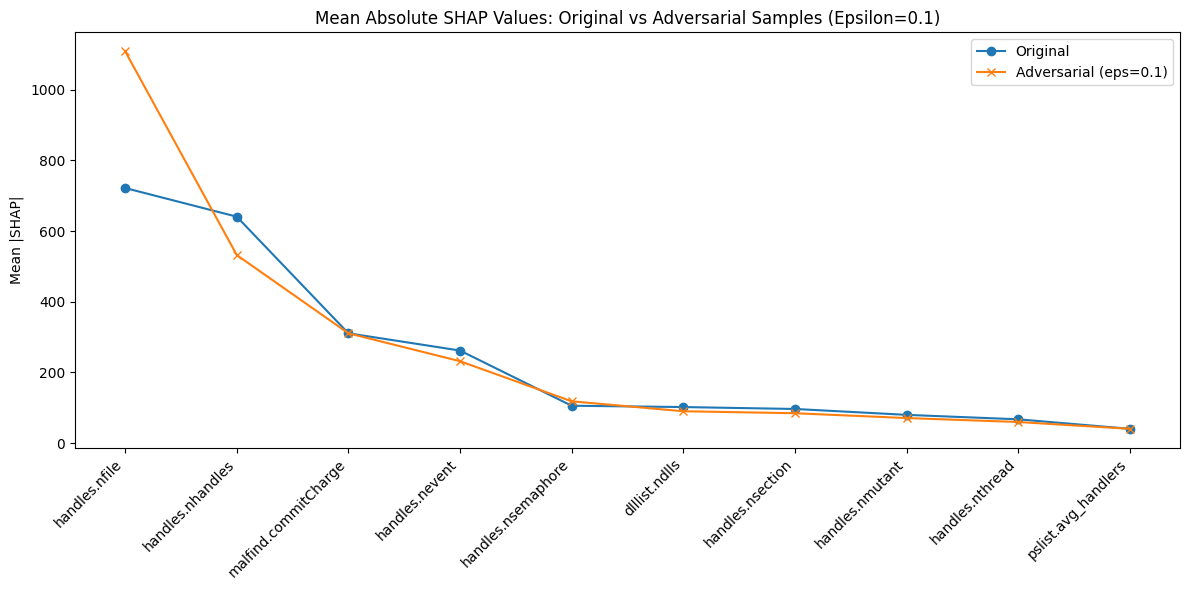


SHAP Value Comparison for epsilon=0.15 (Sorted by Mean SHAP Original):
                               Feature  Mean_SHAP_Original  Mean_SHAP_Adversarial_eps_0.15
                         handles.nfile          721.906403                     1303.050929
                      handles.nhandles          640.734905                      477.943293
                  malfind.commitCharge          310.722960                      310.722960
                        handles.nevent          261.891672                      216.657256
                    handles.nsemaphore          105.695306                      124.495332
                         dlllist.ndlls          101.951634                       84.170433
                      handles.nsection           96.542284                       78.420794
                       handles.nmutant           79.869171                       66.319701
                       handles.nthread           67.295428                       55.865391
                  

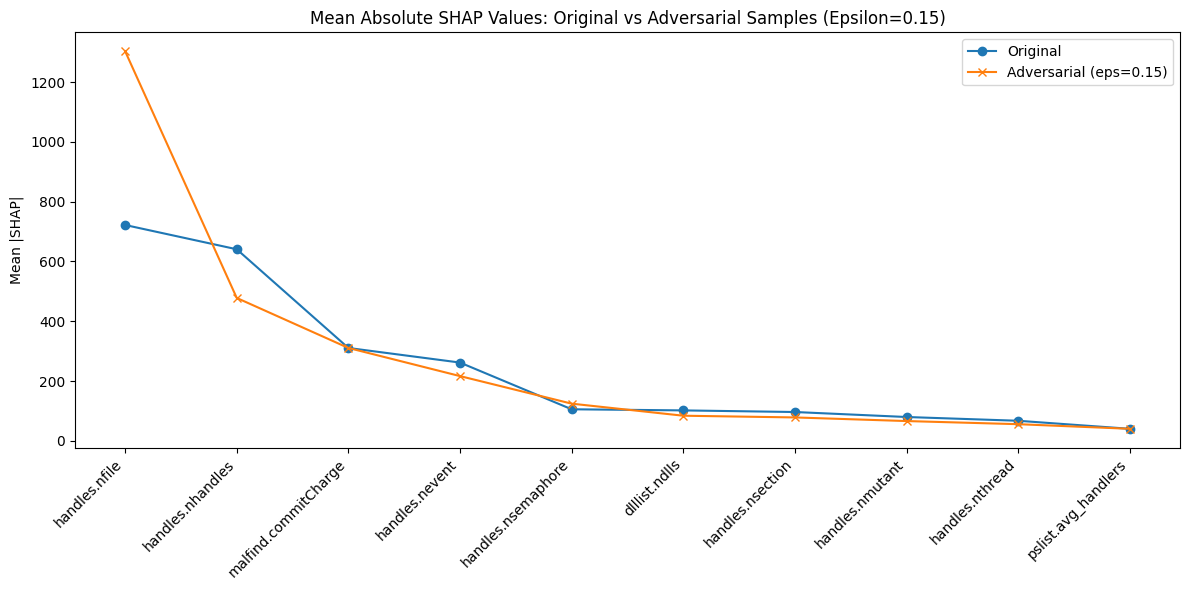


SHAP Value Comparison for epsilon=0.2 (Sorted by Mean SHAP Original):
                               Feature  Mean_SHAP_Original  Mean_SHAP_Adversarial_eps_0.2
                         handles.nfile          721.906403                    1497.019240
                      handles.nhandles          640.734905                     424.739036
                  malfind.commitCharge          310.722960                     310.722960
                        handles.nevent          261.891672                     201.579068
                    handles.nsemaphore          105.695306                     130.762056
                         dlllist.ndlls          101.951634                      78.243402
                      handles.nsection           96.542284                      72.380297
                       handles.nmutant           79.869171                      61.803215
                       handles.nthread           67.295428                      52.055380
                   pslist.avg

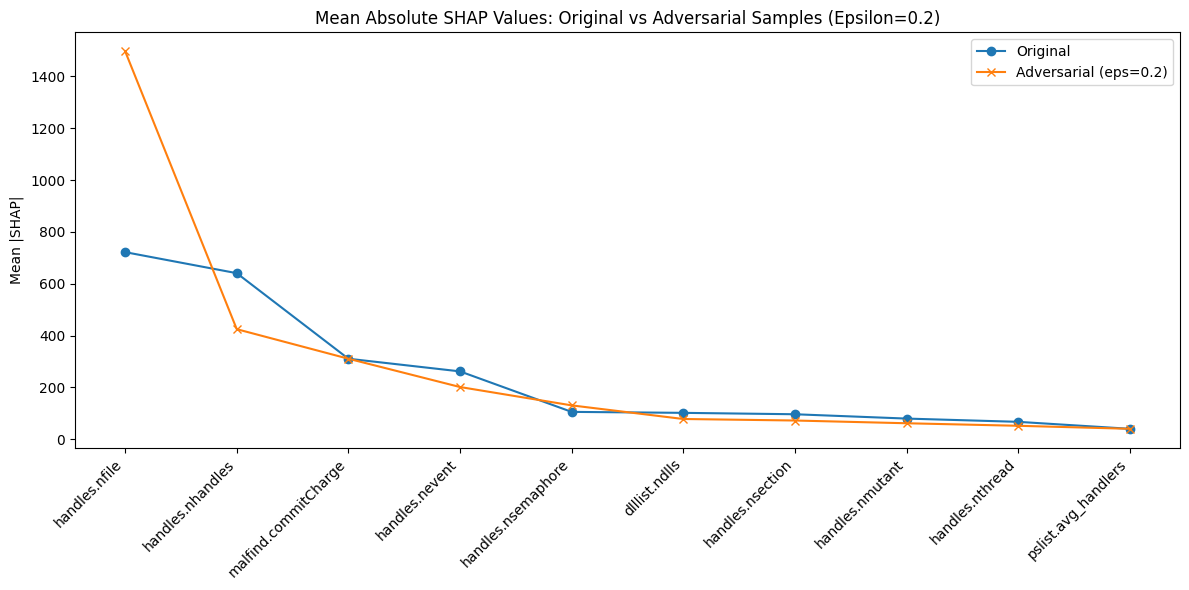

In [45]:
#SHAP Validation:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the LogisticRegression model
model = trained_models['LogisticRegression']
scaler = model.named_steps.get('scaler', None)
model_clf = model.named_steps['clf'] if scaler else model

# Create SHAP explainer (using a subset of X_train for efficiency)
# Note: X_train must be defined from previous cells; adjust subset size as needed
X_train_subset = X_train.sample(100, random_state=42) if len(X_train) > 100 else X_train
explainer = shap.Explainer(model_clf, X_train_subset, feature_names=feature_cols)

# Load original samples
original_samples_df = pd.read_csv("original_fgsm_samples.csv")
X_test_conti = original_samples_df[feature_cols]

# Compute SHAP values for original samples
try:
    shap_values_original = explainer(X_test_conti)
except Exception as e:
    print(f"SHAP computation failed for original samples: {e}")
    raise

# Extract SHAP values for the "Conti" class
conti_encoded = le_catname.transform(["Conti"])[0]
if len(shap_values_original.values.shape) == 3:
    shap_original_conti = shap_values_original.values[:, :, conti_encoded]
else:
    shap_original_conti = shap_values_original.values

# Compute mean absolute SHAP values for original samples
mean_shap_original = np.abs(shap_original_conti).mean(axis=0)

# Initialize comparison DataFrame
comparison_dfs = []

# Compare SHAP values for each epsilon
for eps in epsilon_values:
    # Load adversarial samples
    csv_filename = f"modified_fgsm_samples_{source_model}_eps_{eps}.csv"
    try:
        X_test_adv_df = pd.read_csv(csv_filename)
        X_test_adv = X_test_adv_df[feature_cols]
    except FileNotFoundError:
        print(f"Adversarial samples file not found: {csv_filename}")
        continue
    
    # Compute SHAP values for adversarial samples
    try:
        shap_values_adversarial = explainer(X_test_adv)
    except Exception as e:
        print(f"SHAP computation failed for adversarial samples (eps={eps}): {e}")
        continue
    
    # Extract SHAP values for the "Conti" class
    if len(shap_values_adversarial.values.shape) == 3:
        shap_adversarial_conti = shap_values_adversarial.values[:, :, conti_encoded]
    else:
        shap_adversarial_conti = shap_values_adversarial.values
    
    # Compute mean absolute SHAP values for adversarial samples
    mean_shap_adversarial = np.abs(shap_adversarial_conti).mean(axis=0)
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Feature': feature_cols,
        'Mean_SHAP_Original': mean_shap_original,
        f'Mean_SHAP_Adversarial_eps_{eps}': mean_shap_adversarial
    })
    comparison_df = comparison_df.sort_values(by='Mean_SHAP_Original', ascending=False)
    
    # Save comparison to CSV
    comparison_df.to_csv(f'shap_comparison_original_vs_adversarial_eps_{eps}.csv', index=False)
    print(f"\nSHAP Value Comparison for epsilon={eps} (Sorted by Mean SHAP Original):")
    print(comparison_df.to_string(index=False))
    
    comparison_dfs.append(comparison_df)
    
    # Visualize top features
    top_n = 10
    top_features_df = comparison_df.head(top_n)
    
    plt.figure(figsize=(12, 6))
    plt.plot(top_features_df['Feature'], top_features_df['Mean_SHAP_Original'], marker='o', label='Original')
    plt.plot(top_features_df['Feature'], top_features_df[f'Mean_SHAP_Adversarial_eps_{eps}'], marker='x', label=f'Adversarial (eps={eps})')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Mean Absolute SHAP Values: Original vs Adversarial Samples (Epsilon={eps})')
    plt.ylabel('Mean |SHAP|')
    plt.legend()
    plt.tight_layout()
    plt.show()

Cell 9:Attack Simulation


Evaluating samples (Source: LogisticRegression, Epsilon: 0.0)
Accuracy for LogisticRegression at epsilon=0.0: 0.1000
Total number of evasion samples for LogisticRegression: 90
Number of Conti samples misclassified as Benign: 0

Prediction Distribution for LogisticRegression:
     Variant  Count
      Emotet     21
 Transponder     14
       Conti     10
        Maze     10
       Shade     10
     Refroso      9
        Zeus      9
       Gator      6
180solutions      5
        TIBS      3
        Scar      2
        Pysa      1


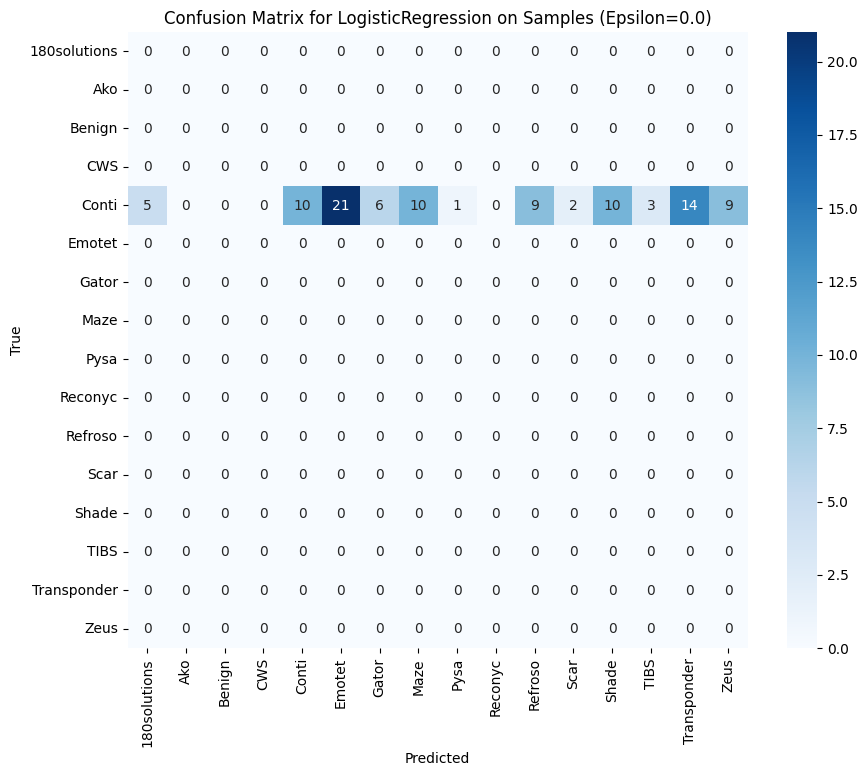

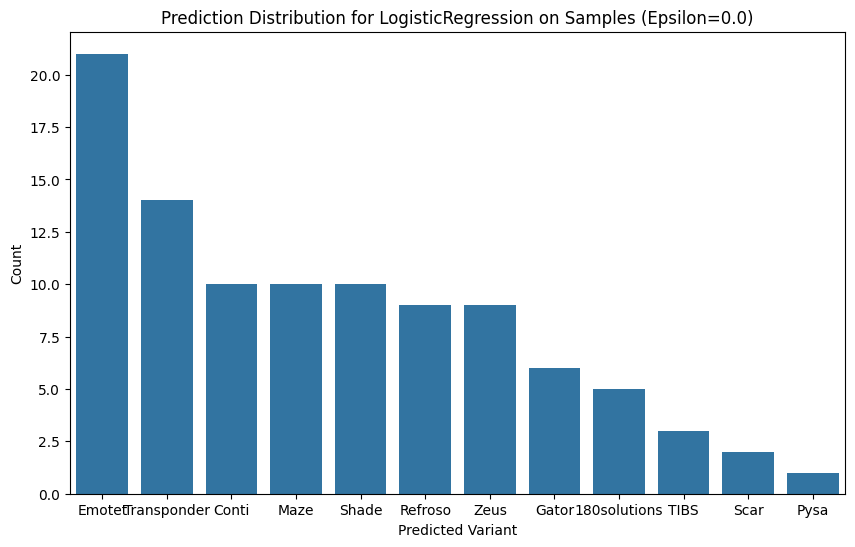

Accuracy for DecisionTree at epsilon=0.0: 0.0000
Total number of evasion samples for DecisionTree: 100
Number of Conti samples misclassified as Benign: 0

Prediction Distribution for DecisionTree:
Variant  Count
 Emotet     97
  Gator      3


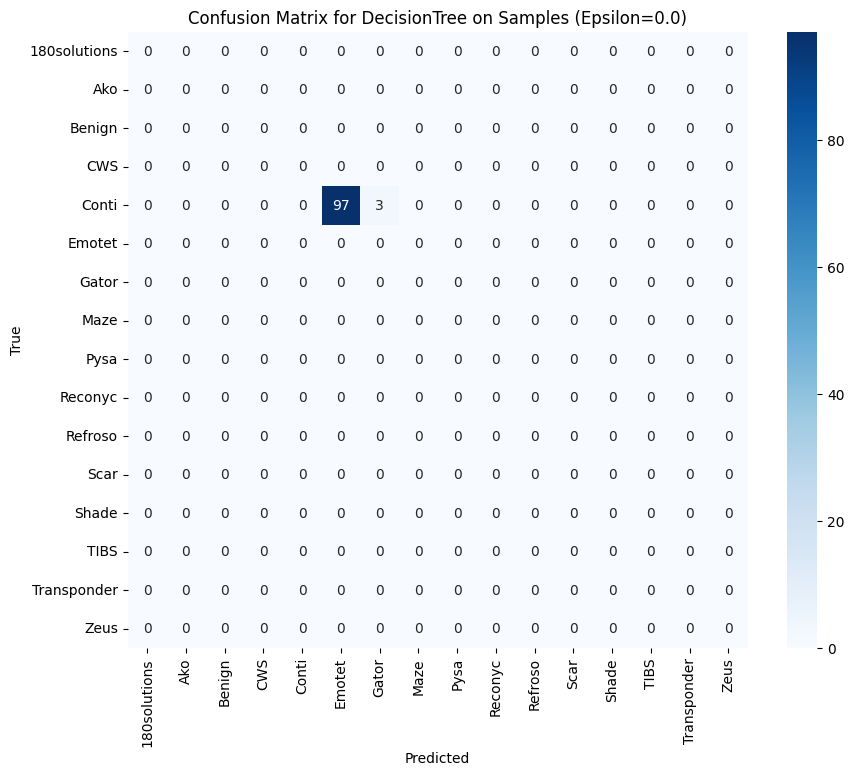

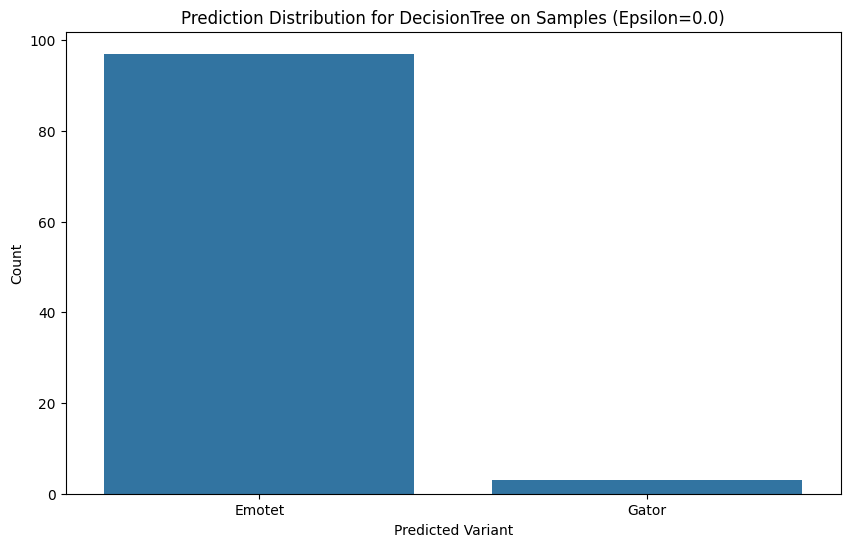

Accuracy for RandomForest at epsilon=0.0: 0.0100
Total number of evasion samples for RandomForest: 99
Number of Conti samples misclassified as Benign: 0

Prediction Distribution for RandomForest:
     Variant  Count
        Zeus     20
      Emotet     20
        Scar     19
        Maze     13
 Transponder     13
       Shade     12
180solutions      2
       Conti      1


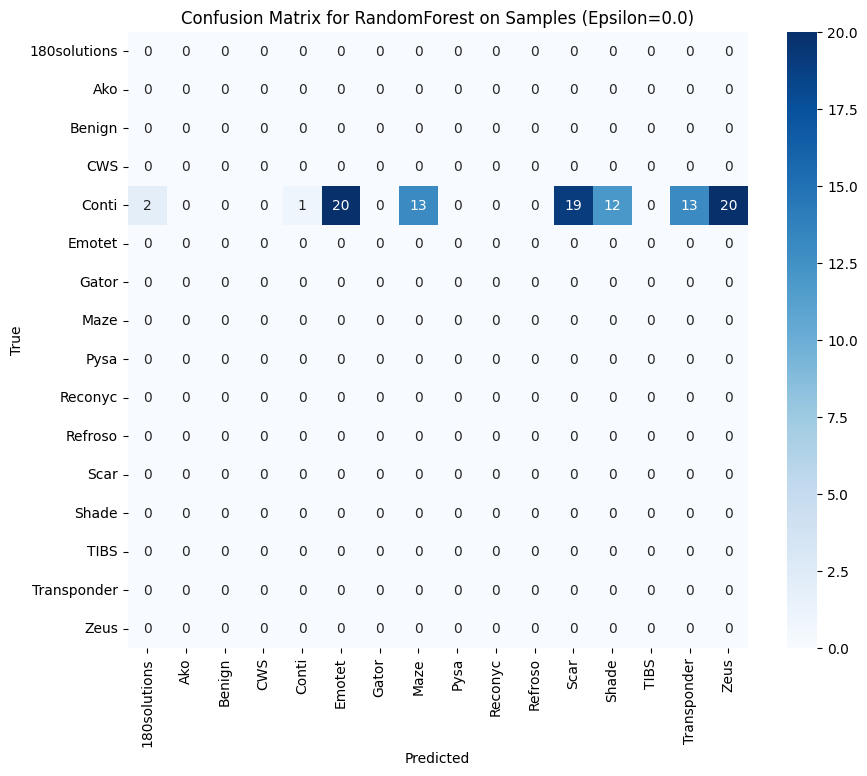

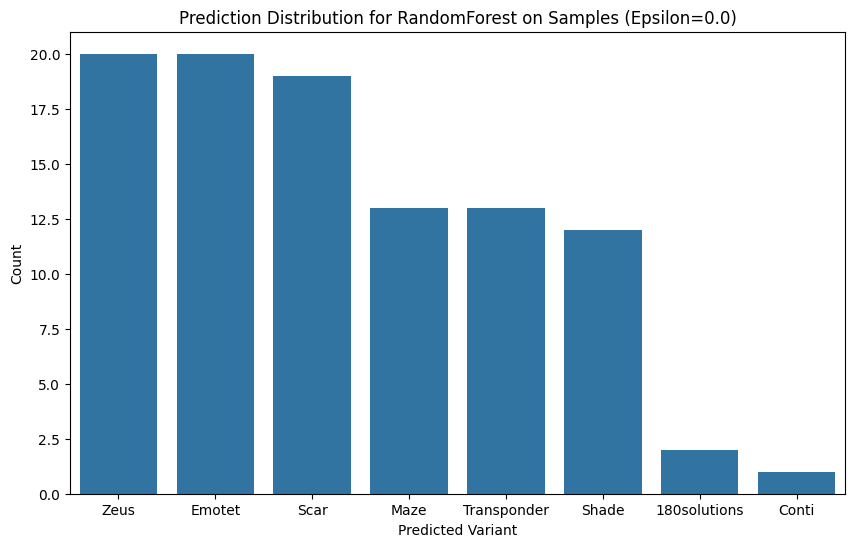


Misclassification distribution saved to 'misclassification_distribution_LogisticRegression_eps_0.0.csv'

Evaluating samples (Source: LogisticRegression, Epsilon: 0.05)
Accuracy for LogisticRegression at epsilon=0.05: 0.0000
Accuracy Drop for LogisticRegression: 0.1000
Total number of evasion samples for LogisticRegression: 100
Number of Conti samples misclassified as Benign: 0

Prediction Distribution for LogisticRegression:
     Variant  Count
     Refroso     24
       Shade     24
      Emotet     22
        Maze      7
        Pysa      6
       Gator      6
 Transponder      5
        Zeus      2
180solutions      2
        Scar      1
     Reconyc      1


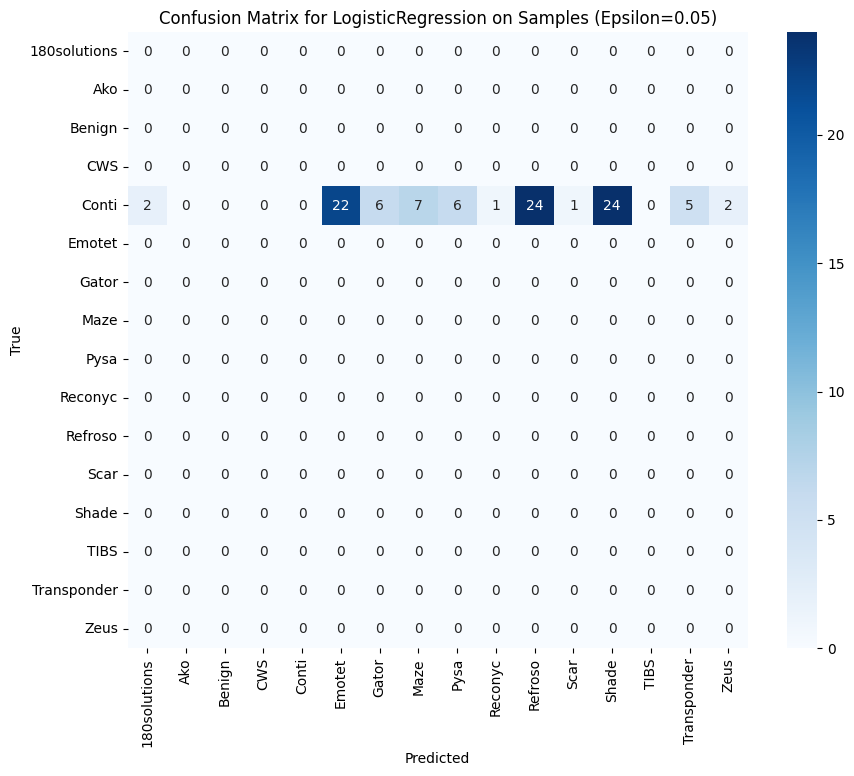

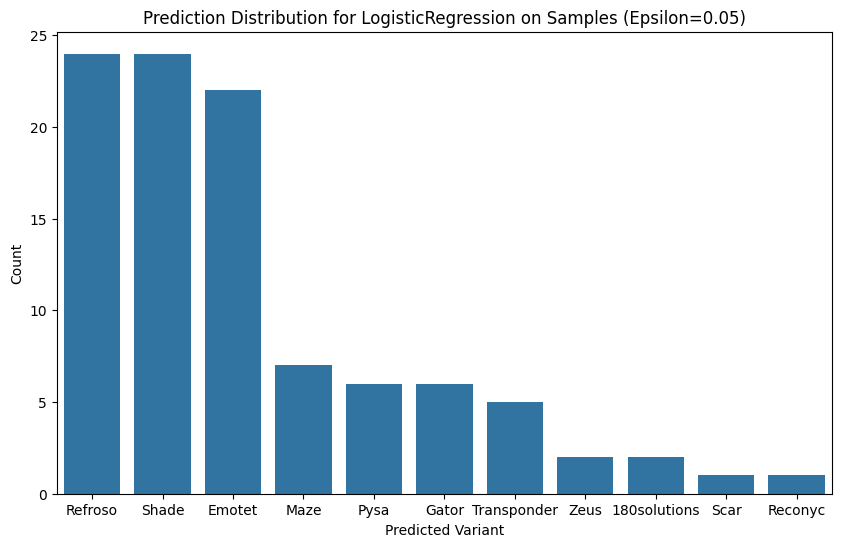

Accuracy for DecisionTree at epsilon=0.05: 0.0000
Accuracy Drop for DecisionTree: 0.0000
Total number of evasion samples for DecisionTree: 100
Number of Conti samples misclassified as Benign: 0

Prediction Distribution for DecisionTree:
Variant  Count
 Emotet     97
  Gator      3


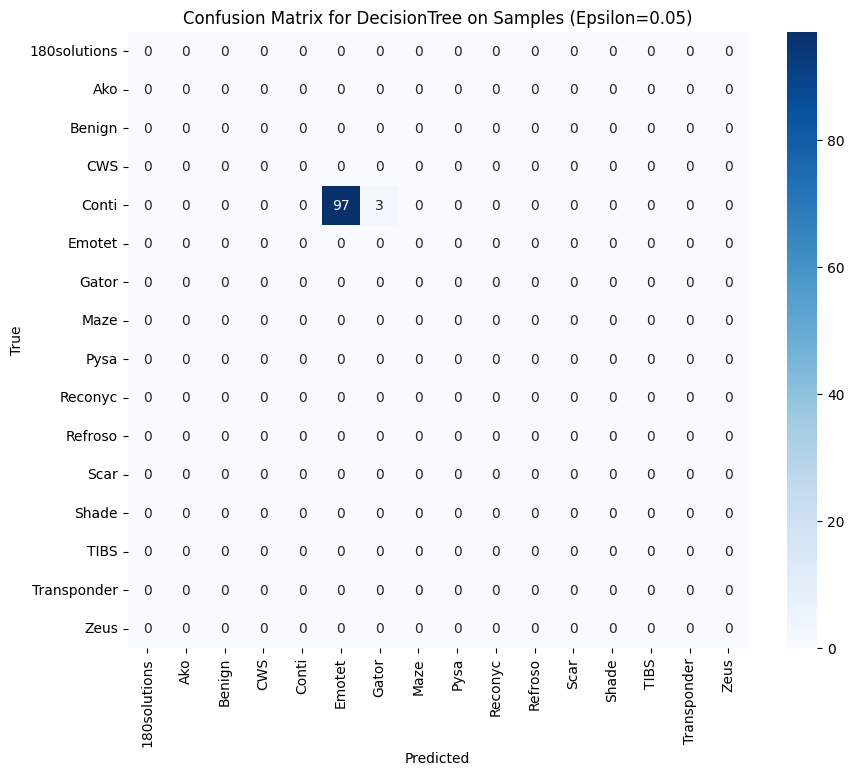

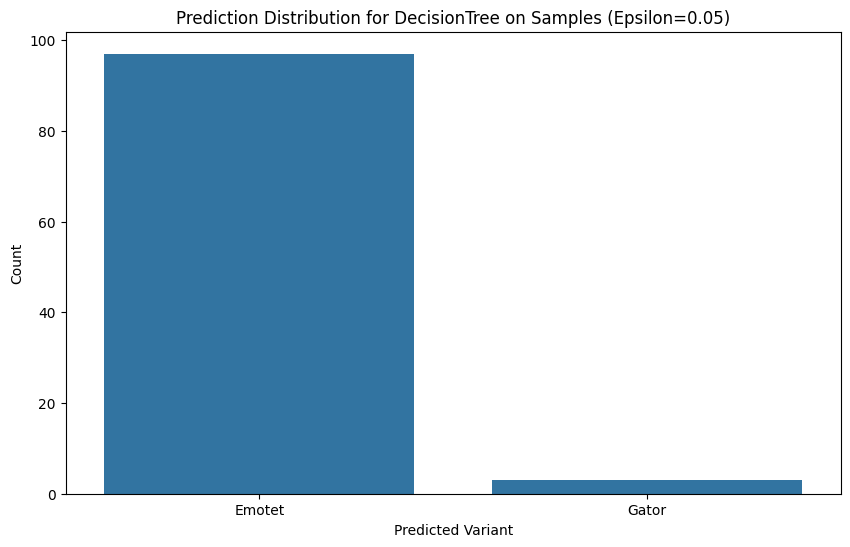

Accuracy for RandomForest at epsilon=0.05: 0.0100
Accuracy Drop for RandomForest: 0.0000
Total number of evasion samples for RandomForest: 99
Number of Conti samples misclassified as Benign: 0

Prediction Distribution for RandomForest:
     Variant  Count
       Shade     63
        Maze     24
        Scar      4
        Zeus      3
 Transponder      2
180solutions      2
       Conti      1
      Emotet      1


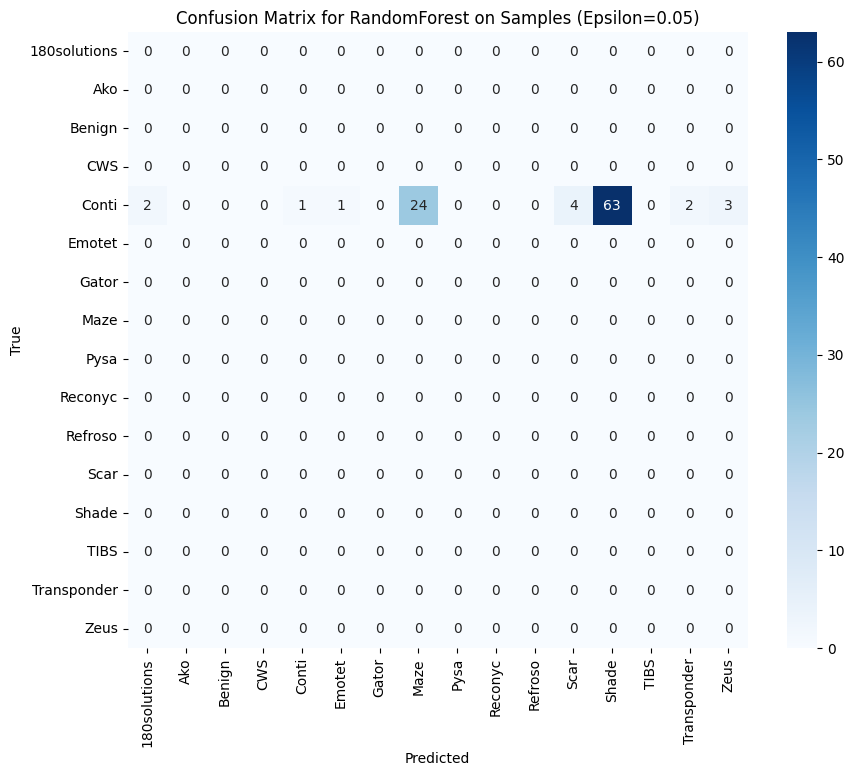

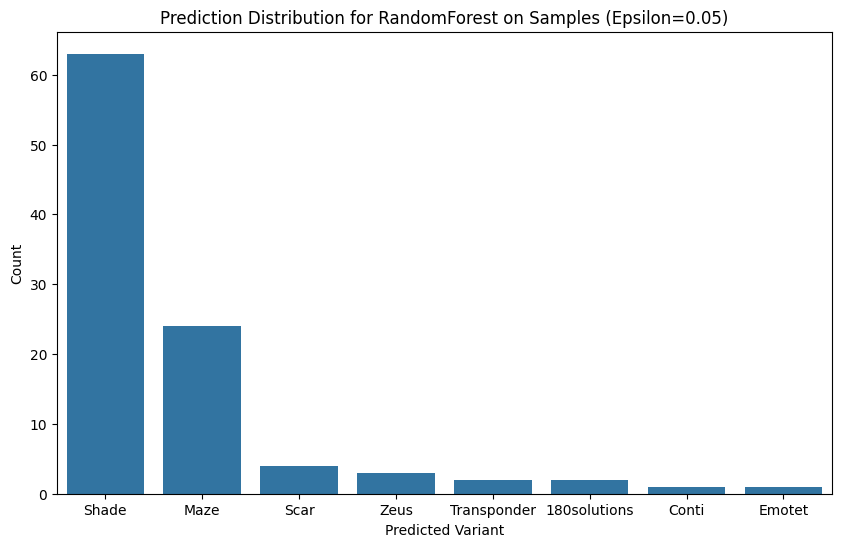


Misclassification distribution saved to 'misclassification_distribution_LogisticRegression_eps_0.05.csv'

Evaluating samples (Source: LogisticRegression, Epsilon: 0.1)
Accuracy for LogisticRegression at epsilon=0.1: 0.0100
Accuracy Drop for LogisticRegression: 0.0900
Total number of evasion samples for LogisticRegression: 99
Number of Conti samples misclassified as Benign: 0

Prediction Distribution for LogisticRegression:
     Variant  Count
     Refroso     32
       Shade     28
        Pysa     20
       Gator      7
      Emotet      6
     Reconyc      3
180solutions      1
        Scar      1
        Maze      1
       Conti      1


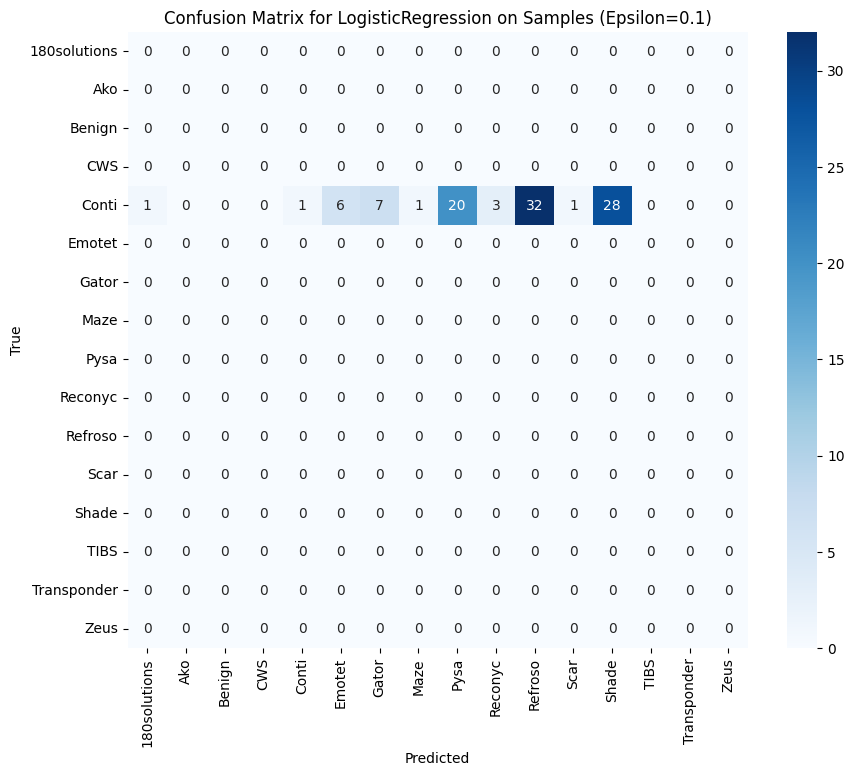

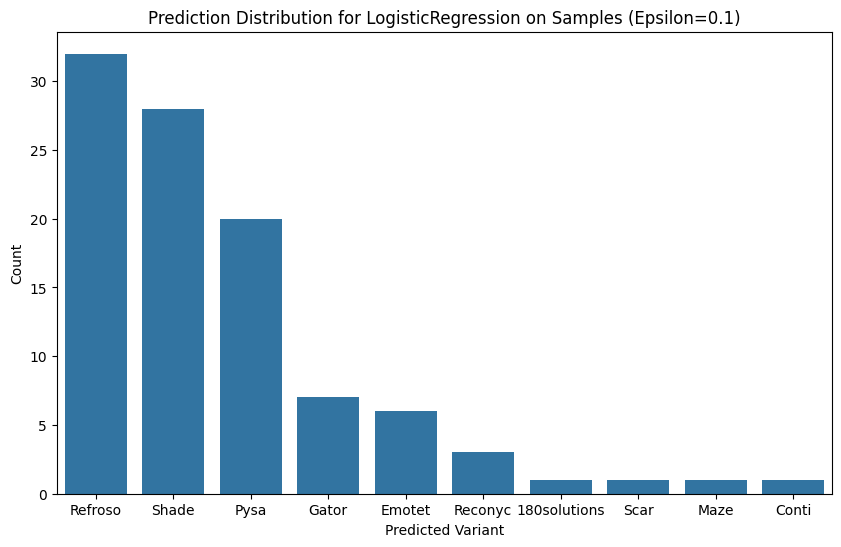

Accuracy for DecisionTree at epsilon=0.1: 0.0000
Accuracy Drop for DecisionTree: 0.0000
Total number of evasion samples for DecisionTree: 100
Number of Conti samples misclassified as Benign: 0

Prediction Distribution for DecisionTree:
Variant  Count
 Emotet     95
  Gator      5


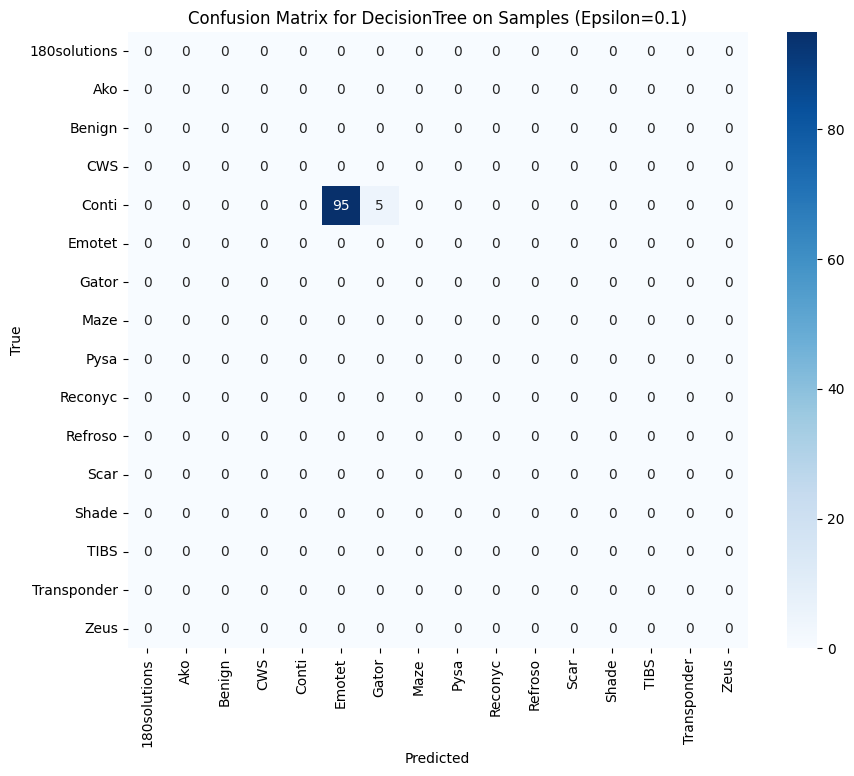

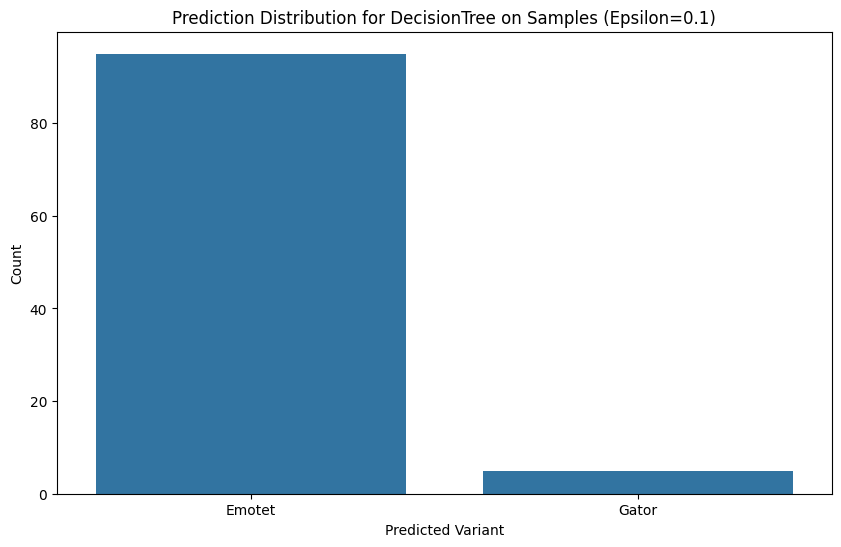

Accuracy for RandomForest at epsilon=0.1: 0.0100
Accuracy Drop for RandomForest: 0.0000
Total number of evasion samples for RandomForest: 99
Number of Conti samples misclassified as Benign: 0

Prediction Distribution for RandomForest:
     Variant  Count
        Maze     46
       Shade     35
 Transponder      5
        Scar      4
        TIBS      4
      Emotet      3
180solutions      2
       Conti      1


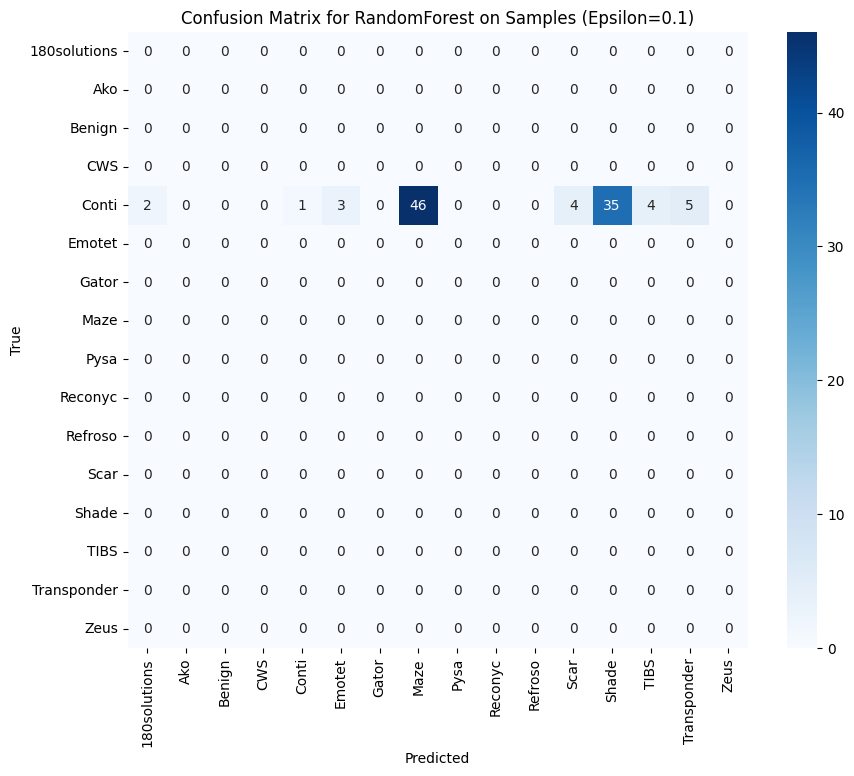

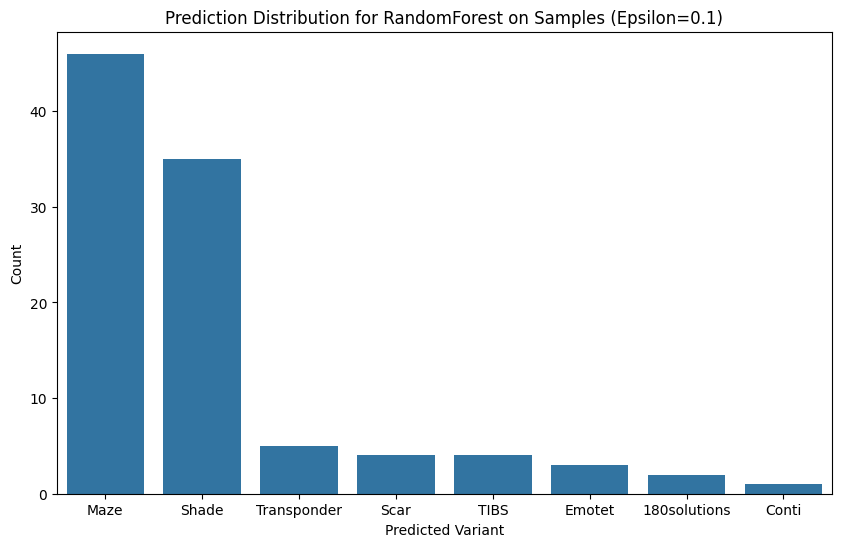


Misclassification distribution saved to 'misclassification_distribution_LogisticRegression_eps_0.1.csv'

Evaluating samples (Source: LogisticRegression, Epsilon: 0.15)
Accuracy for LogisticRegression at epsilon=0.15: 0.0100
Accuracy Drop for LogisticRegression: 0.0900
Total number of evasion samples for LogisticRegression: 99
Number of Conti samples misclassified as Benign: 4

Prediction Distribution for LogisticRegression:
     Variant  Count
     Refroso     41
        Pysa     24
       Shade     16
     Reconyc      8
       Gator      5
      Benign      4
180solutions      1
       Conti      1


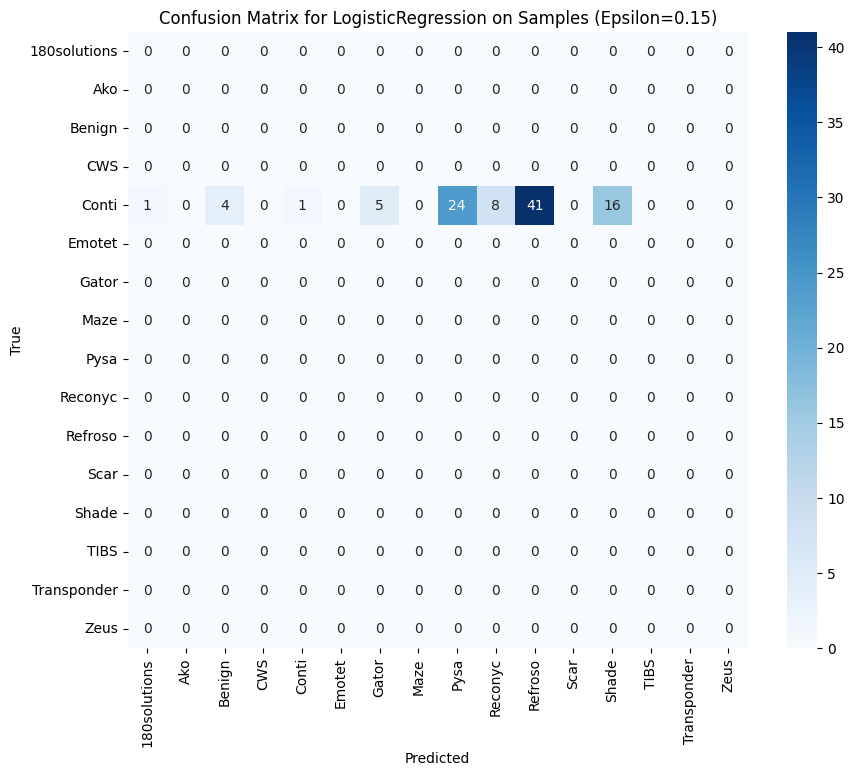

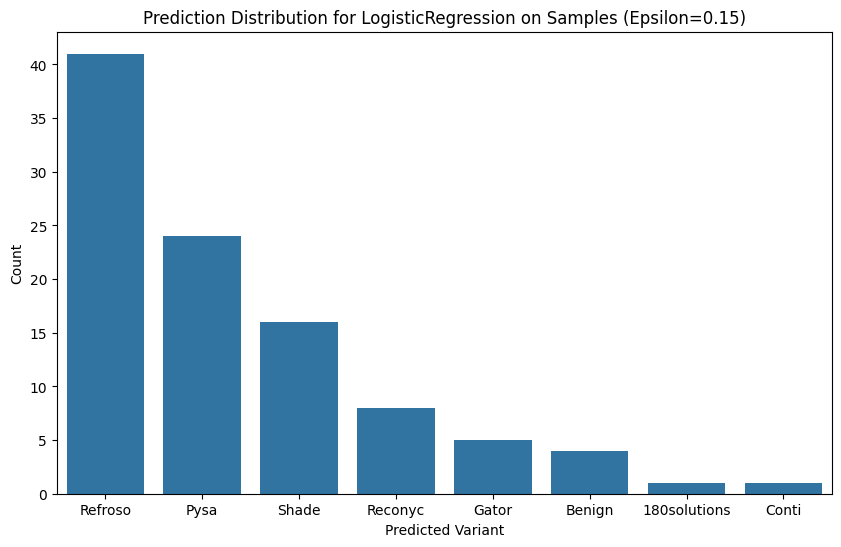

Accuracy for DecisionTree at epsilon=0.15: 0.0000
Accuracy Drop for DecisionTree: 0.0000
Total number of evasion samples for DecisionTree: 100
Number of Conti samples misclassified as Benign: 0

Prediction Distribution for DecisionTree:
    Variant  Count
     Emotet     92
      Gator      7
Transponder      1


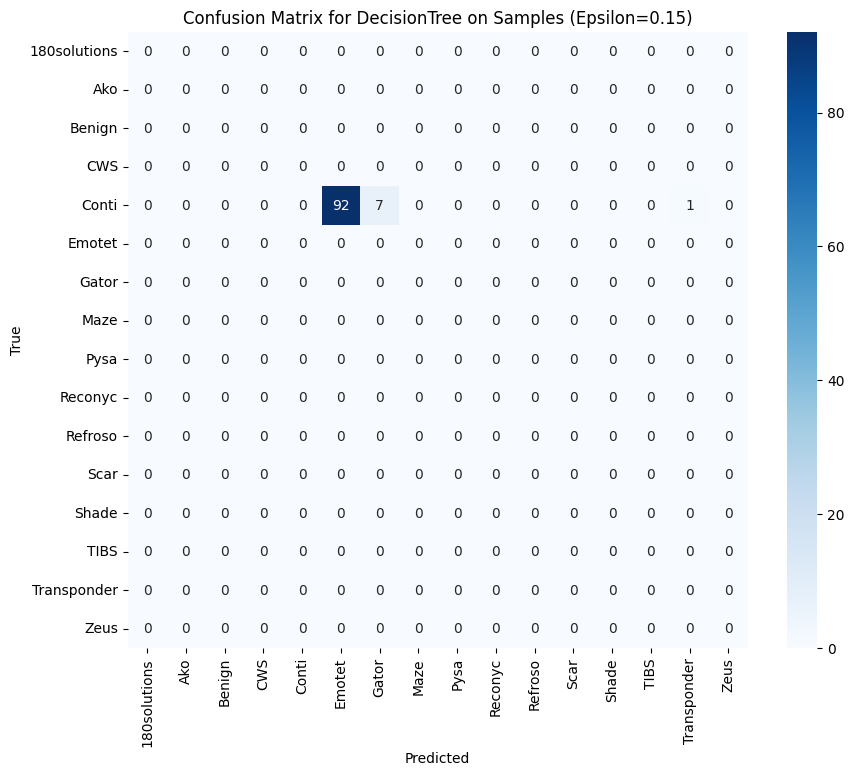

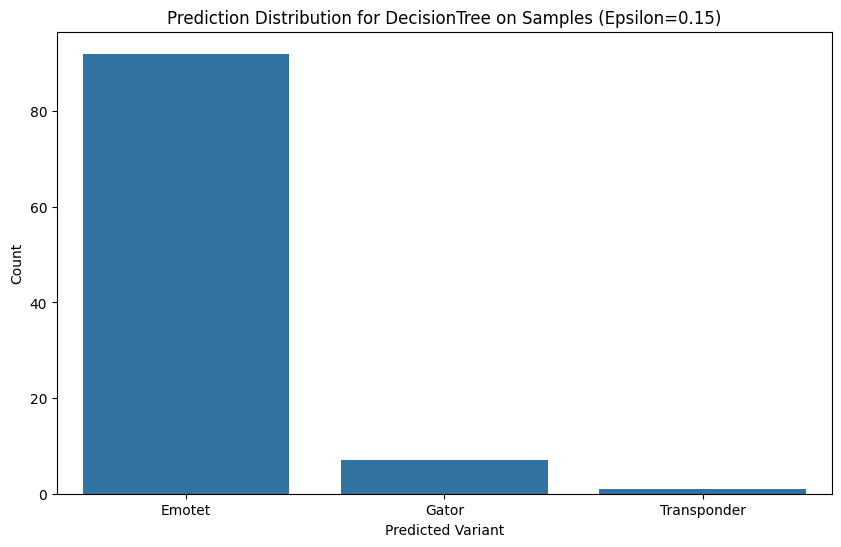

Accuracy for RandomForest at epsilon=0.15: 0.1000
Accuracy Drop for RandomForest: -0.0900
Total number of evasion samples for RandomForest: 90
Number of Conti samples misclassified as Benign: 0

Prediction Distribution for RandomForest:
     Variant  Count
        Maze     27
     Reconyc     26
       Shade     20
       Conti     10
180solutions      6
 Transponder      5
        TIBS      5
     Refroso      1


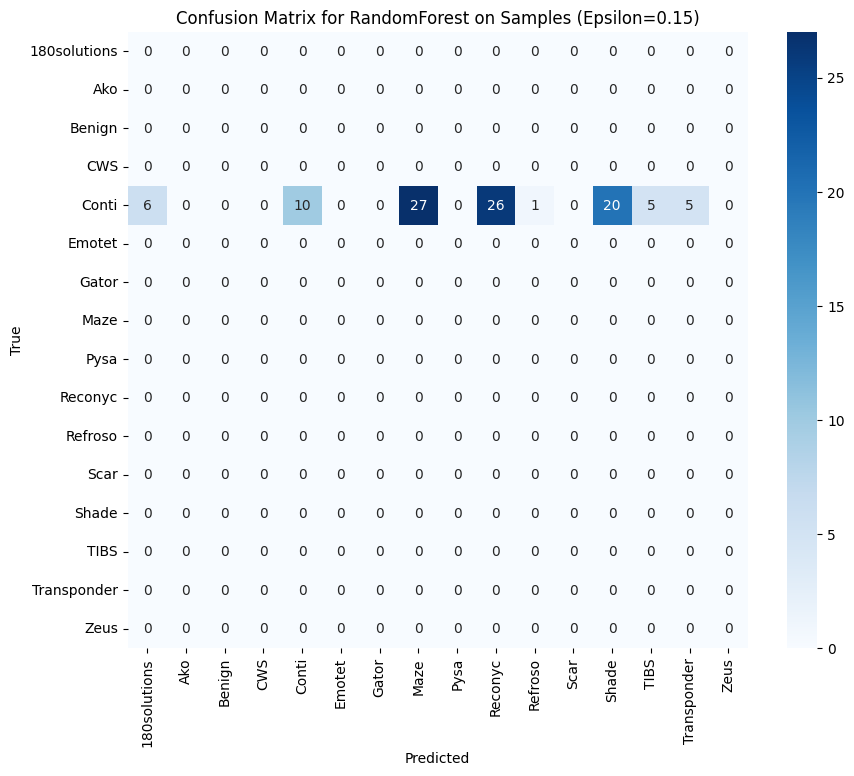

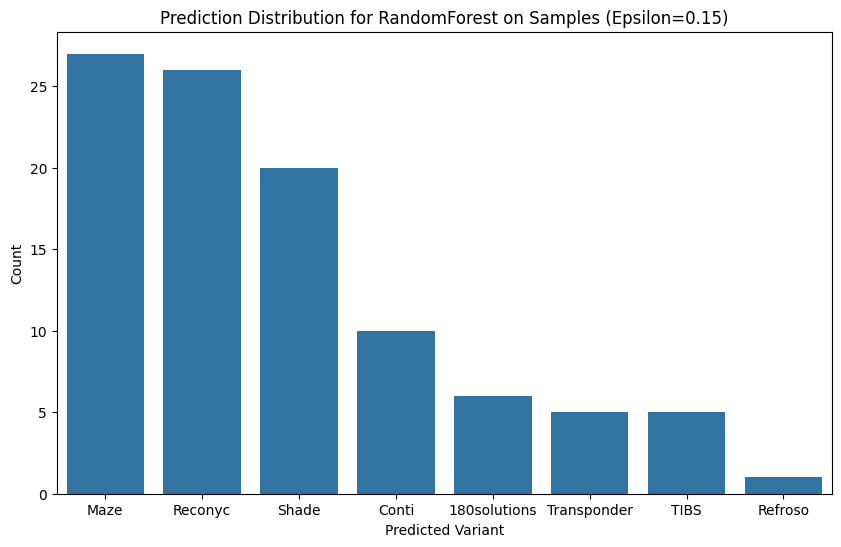


Misclassification distribution saved to 'misclassification_distribution_LogisticRegression_eps_0.15.csv'

Evaluating samples (Source: LogisticRegression, Epsilon: 0.2)
Accuracy for LogisticRegression at epsilon=0.2: 0.0000
Accuracy Drop for LogisticRegression: 0.1000
Total number of evasion samples for LogisticRegression: 100
Number of Conti samples misclassified as Benign: 12

Prediction Distribution for LogisticRegression:
     Variant  Count
     Refroso     40
        Pysa     23
       Shade     13
      Benign     12
     Reconyc      6
       Gator      5
180solutions      1


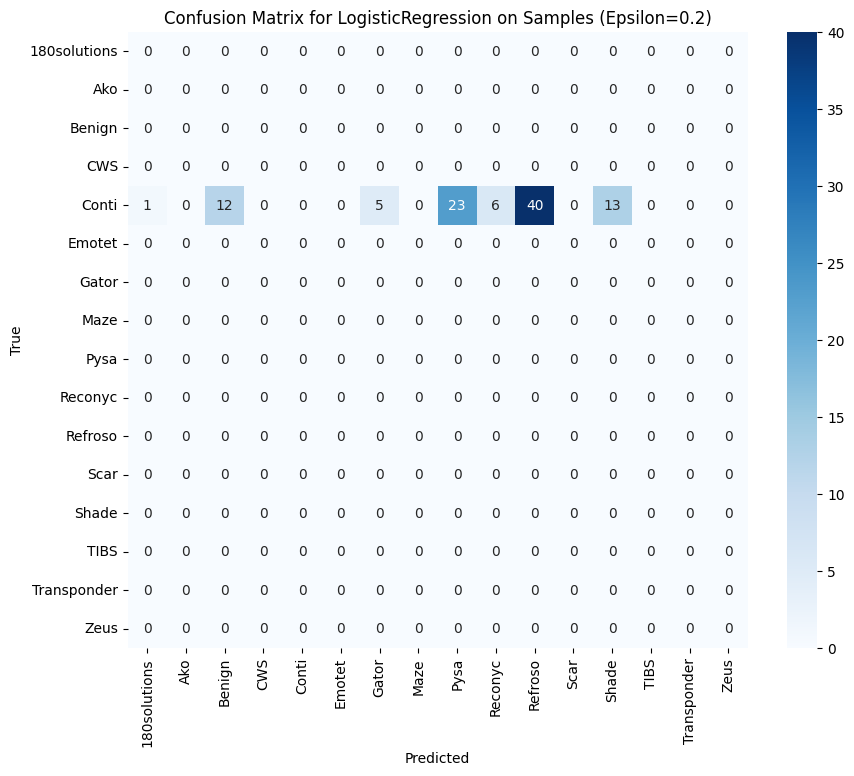

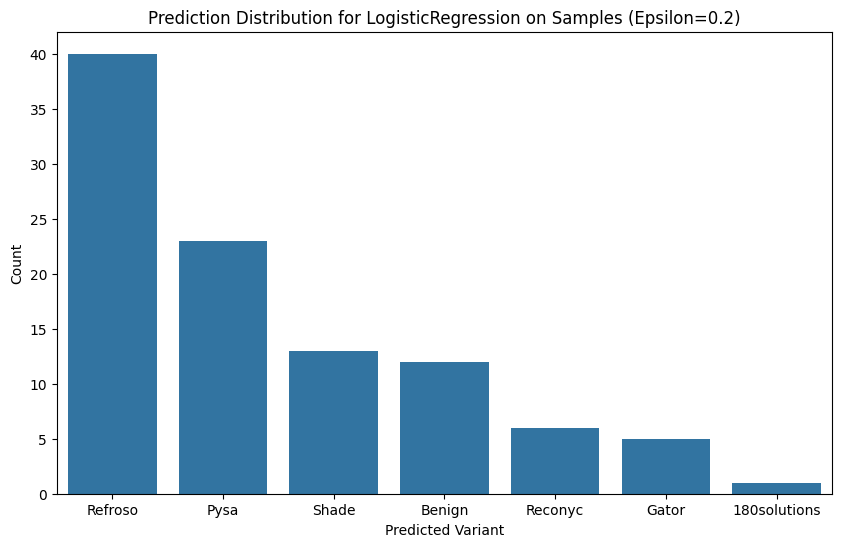

Accuracy for DecisionTree at epsilon=0.2: 0.0000
Accuracy Drop for DecisionTree: 0.0000
Total number of evasion samples for DecisionTree: 100
Number of Conti samples misclassified as Benign: 0

Prediction Distribution for DecisionTree:
    Variant  Count
     Emotet     88
      Gator     11
Transponder      1


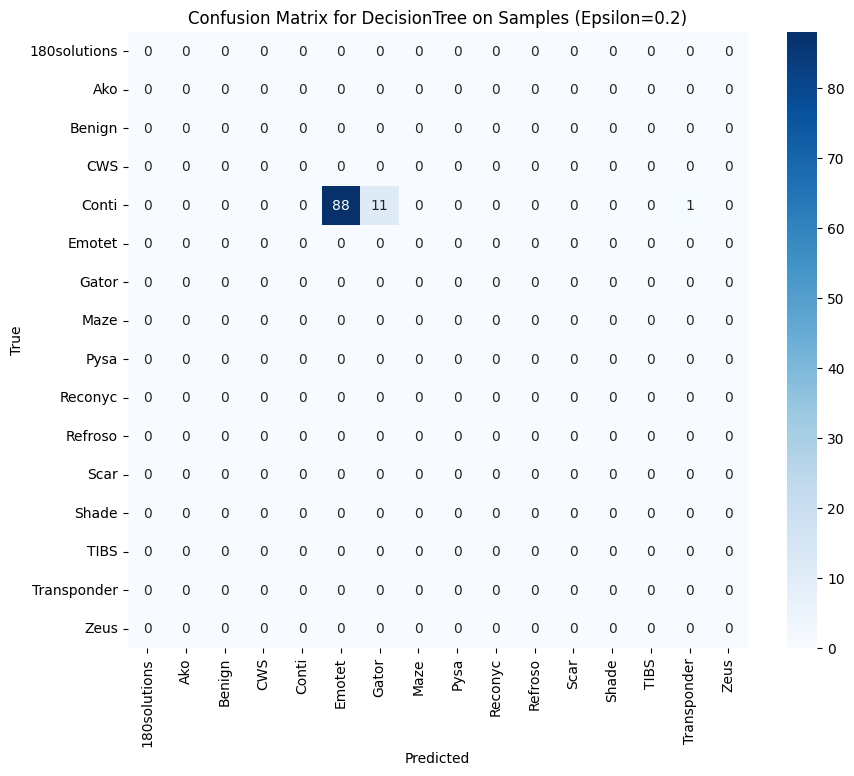

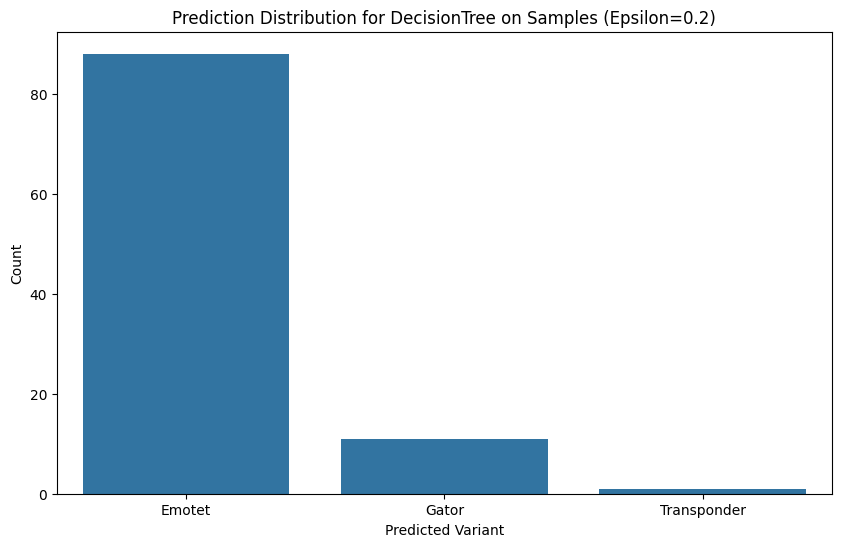

Accuracy for RandomForest at epsilon=0.2: 0.0700
Accuracy Drop for RandomForest: -0.0600
Total number of evasion samples for RandomForest: 93
Number of Conti samples misclassified as Benign: 14

Prediction Distribution for RandomForest:
     Variant  Count
     Reconyc     20
       Shade     19
        Maze     16
180solutions     16
      Benign     14
       Conti      7
        TIBS      4
        Scar      2
 Transponder      1
     Refroso      1


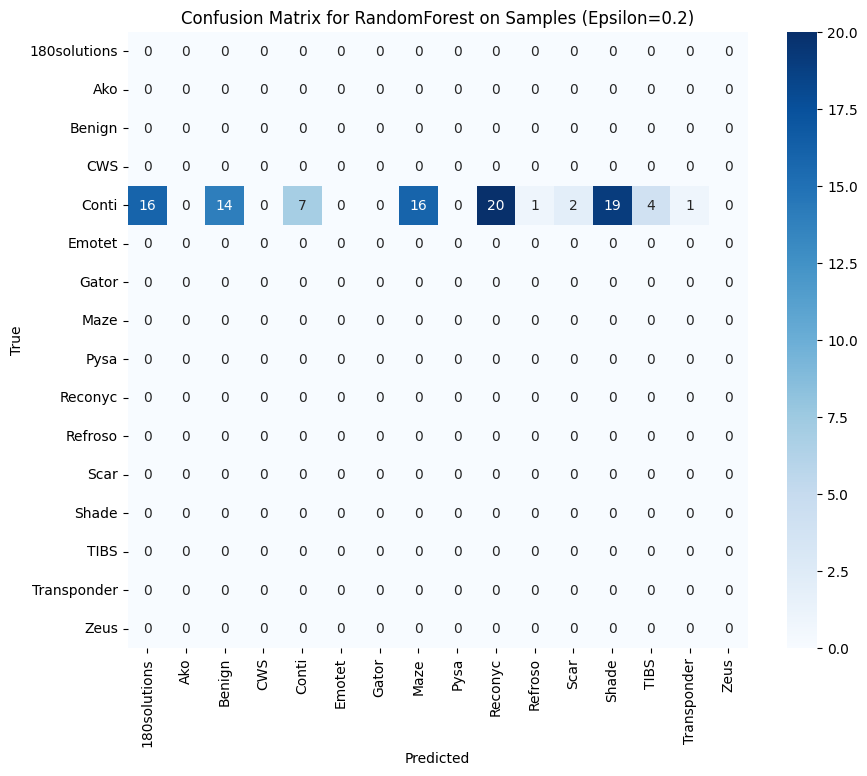

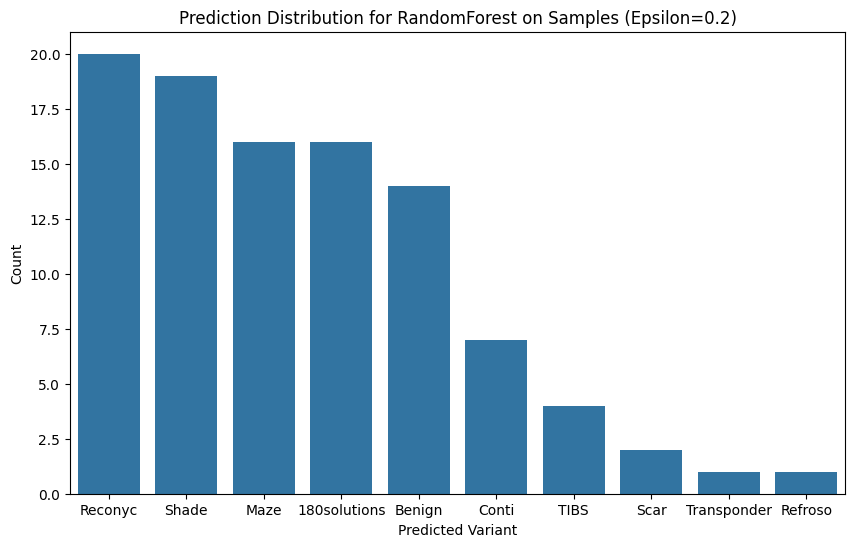


Misclassification distribution saved to 'misclassification_distribution_LogisticRegression_eps_0.2.csv'

Overall accuracy metrics saved to 'adversarial_accuracy_vs_epsilon.csv'


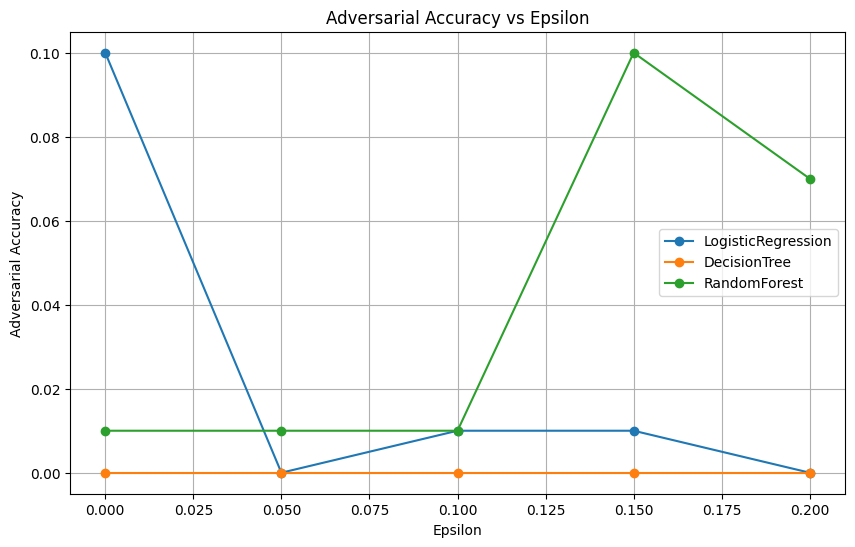


Vulnerability Thresholds (first epsilon where accuracy < 0.5):
LogisticRegression: epsilon = 0.05
DecisionTree: epsilon = 0.05
RandomForest: epsilon = 0.05

Vulnerability Thresholds (first epsilon where accuracy drop > 0.1):
LogisticRegression: epsilon = 0.05
DecisionTree: epsilon = N/A (drop ≤ 0.1)
RandomForest: epsilon = N/A (drop ≤ 0.1)


In [46]:
# Attack Simulation:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define epsilon_values including 0.0 for clean samples
# Note: Ensure your sample generation code sets epsilon_values = [0.0, 0.05, 0.1, 0.15, 0.2]
# and generates original samples for eps = 0.0 accordingly
overall_results = []

# Evaluate samples for each epsilon
for eps in epsilon_values:
    print(f"\nEvaluating samples (Source: {source_model}, Epsilon: {eps})")
    
    # Load samples (for eps=0.0, these are the original samples)
    csv_filename = f"modified_fgsm_samples_{source_model}_eps_{eps}.csv"
    try:
        X_test_adv_df = pd.read_csv(csv_filename)
        X_test_adv_features_only = X_test_adv_df[feature_cols]
    except FileNotFoundError:
        print(f"Samples file not found: {csv_filename}")
        continue
    
    # Define all labels based on the LabelEncoder
    all_labels = np.arange(len(le_catname.classes_))
    
    misclassification_results = []
    
    for clf_name in classifiers:
        model = trained_models[clf_name]
        y_pred_adv = model.predict(X_test_adv_features_only)
        
        # Calculate metrics
        adv_accuracy = (y_pred_adv == y_test_conti).mean()
        # For eps = 0.0, this is the clean accuracy; store it for reference
        if eps == 0.0:
            clean_accuracy = adv_accuracy
        else:
            # Find clean accuracy from eps = 0.0 results
            clean_result = next((r for r in overall_results if r['Classifier'] == clf_name and r['Epsilon'] == 0.0), None)
            clean_accuracy = clean_result['Adversarial_Accuracy'] if clean_result else adv_accuracy
        accuracy_drop = clean_accuracy - adv_accuracy
        
        print(f"Accuracy for {clf_name} at epsilon={eps}: {adv_accuracy:.4f}")
        if eps > 0:
            print(f"Accuracy Drop for {clf_name}: {accuracy_drop:.4f}")
        
        evasion_count = sum(y_pred_adv != y_test_conti)
        print(f"Total number of evasion samples for {clf_name}: {evasion_count}")
        
        benign_misclassified = sum(y_pred_adv == benign_encoded)
        print(f"Number of Conti samples misclassified as Benign: {benign_misclassified}")
        
        # Prediction distribution
        print(f"\nPrediction Distribution for {clf_name}:")
        pred_counts = pd.Series(y_pred_adv).value_counts()
        pred_dist = pd.DataFrame({
            'Variant': le_catname.inverse_transform(pred_counts.index),
            'Count': pred_counts.values
        })
        print(pred_dist.to_string(index=False))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test_conti, y_pred_adv, labels=all_labels)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=le_catname.classes_, yticklabels=le_catname.classes_)
        plt.title(f'Confusion Matrix for {clf_name} on Samples (Epsilon={eps})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
        # Plot prediction distribution bar plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Variant', y='Count', data=pred_dist)
        plt.title(f'Prediction Distribution for {clf_name} on Samples (Epsilon={eps})')
        plt.xlabel('Predicted Variant')
        plt.ylabel('Count')
        plt.show()
        
        # Store detailed misclassification results
        for variant, count in zip(le_catname.inverse_transform(pred_counts.index), pred_counts.values):
            misclassification_results.append({
                'Source_Model': source_model,
                'Epsilon': eps,
                'Eval_Model': clf_name,
                'Variant': variant,
                'Count': count,
                'Evasion_Count': evasion_count,
                'Benign_Count': benign_misclassified if variant == 'Benign' else 0,
                'Clean_Accuracy': clean_accuracy,
                'Adversarial_Accuracy': adv_accuracy,
                'Accuracy_Drop': accuracy_drop
            })
        
        # Store overall metrics
        overall_results.append({
            'Epsilon': eps,
            'Classifier': clf_name,
            'Clean_Accuracy': clean_accuracy,
            'Adversarial_Accuracy': adv_accuracy,
            'Accuracy_Drop': accuracy_drop
        })
    
    # Save misclassification distribution
    misclassification_df = pd.DataFrame(misclassification_results)
    csv_filename = f"misclassification_distribution_{source_model}_eps_{eps}.csv"
    misclassification_df.to_csv(csv_filename, index=False)
    print(f"\nMisclassification distribution saved to '{csv_filename}'")

# Convert overall results to DataFrame
overall_df = pd.DataFrame(overall_results)
overall_df.to_csv('adversarial_accuracy_vs_epsilon.csv', index=False)
print("\nOverall accuracy metrics saved to 'adversarial_accuracy_vs_epsilon.csv'")

# Plot Adversarial Accuracy vs Epsilon
plt.figure(figsize=(10, 6))
for clf_name in classifiers:
    clf_data = overall_df[overall_df['Classifier'] == clf_name]
    plt.plot(clf_data['Epsilon'], clf_data['Adversarial_Accuracy'], marker='o', label=clf_name)
plt.xlabel('Epsilon')
plt.ylabel('Adversarial Accuracy')
plt.title('Adversarial Accuracy vs Epsilon')
plt.legend()
plt.grid(True)
plt.show()

# Record Vulnerability Thresholds
## Option 1: When accuracy drops below 50%
threshold = 0.5
vulnerability_thresholds = {}
for clf_name in classifiers:
    clf_data = overall_df[(overall_df['Classifier'] == clf_name) & (overall_df['Epsilon'] > 0)].sort_values('Epsilon')
    below_threshold = clf_data[clf_data['Adversarial_Accuracy'] < threshold]
    if not below_threshold.empty:
        min_eps = below_threshold['Epsilon'].min()
        vulnerability_thresholds[clf_name] = min_eps
    else:
        vulnerability_thresholds[clf_name] = None

print("\nVulnerability Thresholds (first epsilon where accuracy < 0.5):")
for clf_name, eps in vulnerability_thresholds.items():
    print(f"{clf_name}: epsilon = {eps if eps is not None else 'N/A (accuracy remained ≥ 0.5)'}")

## Option 2: When accuracy drops by more than 5%
drop_threshold = 0.05
vulnerability_thresholds_drop = {}
for clf_name in classifiers:
    clf_data = overall_df[(overall_df['Classifier'] == clf_name) & (overall_df['Epsilon'] > 0)].sort_values('Epsilon')
    significant_drop = clf_data[clf_data['Accuracy_Drop'] > drop_threshold]
    if not significant_drop.empty:
        min_eps = significant_drop['Epsilon'].min()
        vulnerability_thresholds_drop[clf_name] = min_eps
    else:
        vulnerability_thresholds_drop[clf_name] = None

print("\nVulnerability Thresholds (first epsilon where accuracy drop > 0.1):")
for clf_name, eps in vulnerability_thresholds_drop.items():
    print(f"{clf_name}: epsilon = {eps if eps is not None else 'N/A (drop ≤ 0.1)'}")

In [52]:
#Generates 1000 Adversarial Malware Samples - with feature preservation == to conti sample feature analysis

import pandas as pd
import numpy as np
import joblib
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier

# Load pre-trained LogisticRegression model for generating adversarial samples
source_model = 'LogisticRegression'
try:
    model = joblib.load(f"{source_model}_AA_model.pkl")
except FileNotFoundError:
    print(f"Error: Model file '{source_model}_AA_model.pkl' not found. Ensure Cell 5 ran successfully.")
    raise

scaler = model.named_steps.get('scaler', None)
model_clf = model.named_steps['clf'] if scaler else model

# Prepare training data for adversarial sample generation
X_train_scaled = scaler.transform(X_train) if scaler else X_train.values

# Create SklearnClassifier for ART
classifier = SklearnClassifier(model=model_clf)

# Define epsilon for adversarial training (based on vulnerability analysis, e.g., Cell 9)
epsilon = 0.1  # Adjust based on where accuracy drops significantly (e.g., >0.05)

# Target 'Benign' for adversarial attack
benign_encoded = le_catname.transform(['Benign'])[0]

# Select only malware samples (exclude 'Benign') from training set
malware_mask = y_train != benign_encoded
X_train_malware = X_train[malware_mask]
X_train_malware_scaled = X_train_scaled[malware_mask]
y_train_malware = y_train[malware_mask]

# Verify alignment
if len(X_train_malware) != len(X_train_malware_scaled) or len(X_train_malware) != len(y_train_malware):
    print(f"Error: Mismatch in sample counts: X_train_malware ({len(X_train_malware)}), "
          f"X_train_malware_scaled ({len(X_train_malware_scaled)}), y_train_malware ({len(y_train_malware)})")
    raise ValueError("Data alignment issue")

# Define number of samples to generate
n_samples = 1000  # Adjust as needed (e.g., 500, 2000)

# Randomly sample n_samples from malware samples
if len(X_train_malware) < n_samples:
    print(f"Warning: Only {len(X_train_malware)} malware samples available. Using all available samples.")
    selected_indices = X_train_malware.index
else:
    selected_indices = np.random.choice(X_train_malware.index, n_samples, replace=False)

# Get subset of malware samples
X_train_subset = X_train_malware.loc[selected_indices]
y_train_subset = y_train_malware.loc[selected_indices]

# Map DataFrame indices to NumPy array positions
malware_indices = X_train_malware.index
positional_indices = [np.where(malware_indices == idx)[0][0] for idx in selected_indices]
X_train_subset_scaled = X_train_malware_scaled[positional_indices]

# Define critical features not to modify (Conti-specific)
"""
features_not_to_modify = [
    "malfind.uniqueInjections", "malfind.protection", "malfind.commitCharge",
    "pslist.avg_threads", "malfind.ninjections", "pslist.avg_handlers",
    "psxview.not_in_deskthrd_false_avg", "pslist.nppid", "pslist.nproc",
    "svcscan.kernel_drivers", "psxview.not_in_eprocess_pool_false_avg",
    "callbacks.ngeneric", "callbacks.nanonymous", "pslist.nprocs64bit",
    "psxview.not_in_eprocess_pool", "psxview.not_in_ethread_pool",
    "psxview.not_in_pslist", "psxview.not_in_pspcid_list", "psxview.not_in_session",
    "psxview.not_in_pspcid_list_false_avg", "callbacks.ncallbacks",
    "psxview.not_in_session_false_avg", "psxview.not_in_ethread_pool_false_avg",
    "psxview.not_in_deskthrd", "psxview.not_in_csrss_handles_false_avg",
    "psxview.not_in_pslist_false_avg", "psxview.not_in_csrss_handles",
    "pslist.avg_handlers", "psxview.not_in_deskthrd_false_avg", "pslist.nppid"
]
"""
features_not_to_modify = [
    "malfind.uniqueInjections"
]

# Validate critical features
indices_not_to_modify = []
for feat in features_not_to_modify:
    if feat in X_train.columns:
        indices_not_to_modify.append(X_train.columns.get_loc(feat))
    else:
        print(f"Warning: Feature '{feat}' not found in X_train.columns")

# Generate adversarial samples
fgsm = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=True)
X_train_adv_scaled = fgsm.generate(X_train_subset_scaled, y=np.full(len(X_train_subset_scaled), benign_encoded))

# Preserve critical features
X_train_adv_scaled[:, indices_not_to_modify] = X_train_subset_scaled[:, indices_not_to_modify]

# Inverse transform to original space if scaled
X_train_adv = scaler.inverse_transform(X_train_adv_scaled) if scaler else X_train_adv_scaled

# Create DataFrame for adversarial samples
X_train_adv_df = pd.DataFrame(X_train_adv, columns=feature_cols)
X_train_adv_df['category_name_encoded'] = y_train_subset.values  # Original malware labels

# Save adversarial training samples
X_train_adv_df.to_csv("n_adversarial_training_samples.csv", index=False)
print(f"Saved {len(X_train_adv_df)} adversarial training samples to 'n_adversarial_training_samples.csv'")

Saved 1000 adversarial training samples to 'n_adversarial_training_samples.csv'


In [ ]:
"""#Generate samples for adversarial retraining from all malware samples:
import pandas as pd
import numpy as np
import joblib
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier

# Load pre-trained LogisticRegression model for generating adversarial samples
source_model = 'LogisticRegression'
model = joblib.load(f"{source_model}_AA_model.pkl")
scaler = model.named_steps.get('scaler', None)
model_clf = model.named_steps['clf'] if scaler else model

# Prepare training data for adversarial sample generation
X_train_scaled = scaler.transform(X_train) if scaler else X_train.values

# Create SklearnClassifier for ART
classifier = SklearnClassifier(model=model_clf)

# Define epsilon for adversarial training (based on vulnerability analysis, e.g., Cell 9)
epsilon = 0.1  # Adjust based on where accuracy drops significantly (e.g., >0.05)

# Target 'Benign' for adversarial attack
benign_encoded = le_catname.transform(['Benign'])[0]

# Select only malware samples (exclude 'Benign') from training set
malware_mask = y_train != benign_encoded
X_train_malware = X_train[malware_mask]
X_train_malware_scaled = X_train_scaled[malware_mask]

# Define critical features not to modify (from Cell 7)
features_not_to_modify = [
    "malfind.uniqueInjections", "malfind.protection", "malfind.commitCharge",
    "pslist.avg_threads", "malfind.ninjections", "pslist.avg_handlers",
    "psxview.not_in_deskthrd_false_avg", "pslist.nppid", "pslist.nproc",
    "svcscan.kernel_drivers", "psxview.not_in_eprocess_pool_false_avg",
    "callbacks.ngeneric", "callbacks.nanonymous", "pslist.nprocs64bit",
    "psxview.not_in_eprocess_pool", "psxview.not_in_ethread_pool",
    "psxview.not_in_pslist", "psxview.not_in_pspcid_list", "psxview.not_in_session",
    "psxview.not_in_pspcid_list_false_avg", "callbacks.ncallbacks",
    "psxview.not_in_session_false_avg", "psxview.not_in_ethread_pool_false_avg",
    "psxview.not_in_deskthrd", "psxview.not_in_csrss_handles_false_avg",
    "psxview.not_in_pslist_false_avg", "psxview.not_in_csrss_handles",
    "pslist.avg_handlers", "psxview.not_in_deskthrd_false_avg", "pslist.nppid"
]
indices_not_to_modify = [X_train.columns.get_loc(feat) for feat in features_not_to_modify if feat in X_train.columns]

# Generate adversarial samples
fgsm = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=True)
X_train_adv_scaled = fgsm.generate(X_train_malware_scaled, y=np.full(len(X_train_malware_scaled), benign_encoded))

# Preserve critical features
X_train_adv_scaled[:, indices_not_to_modify] = X_train_malware_scaled[:, indices_not_to_modify]

# Inverse transform to original space if scaled
X_train_adv = scaler.inverse_transform(X_train_adv_scaled) if scaler else X_train_adv_scaled

# Create DataFrame for adversarial samples
X_train_adv_df = pd.DataFrame(X_train_adv, columns=feature_cols)
X_train_adv_df['category_name_encoded'] = y_train[malware_mask].values  # Original malware labels

# Save adversarial training samples
X_train_adv_df.to_csv("adversarial_training_samples.csv", index=False)
print("Saved adversarial training samples to 'adversarial_training_samples.csv'")"""

Saved adversarial training samples to 'adversarial_training_samples.csv'


In [49]:
#Generate 1000 adversarial conti samples.
"""
#adversarial conti samples

import pandas as pd
import numpy as np
import joblib
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import SklearnClassifier

# Load pre-trained LogisticRegression model for generating adversarial samples
source_model = 'LogisticRegression'
try:
    model = joblib.load(f"{source_model}_AA_model.pkl")
except FileNotFoundError:
    print(f"Error: Model file '{source_model}_AA_model.pkl' not found. Ensure Cell 5 ran successfully.")
    raise

scaler = model.named_steps.get('scaler', None)
model_clf = model.named_steps['clf'] if scaler else model

# Prepare training data for adversarial sample generation
X_train_scaled = scaler.transform(X_train) if scaler else X_train.values

# Create SklearnClassifier for ART
classifier = SklearnClassifier(model=model_clf)

# Define epsilon for adversarial training (based on vulnerability analysis, e.g., Cell 9)
epsilon = 0.1  # Adjust based on where accuracy drops significantly (e.g., >0.05)

# Target 'Benign' for adversarial attack
benign_encoded = le_catname.transform(['Benign'])[0]
conti_encoded = le_catname.transform(['Conti'])[0]

# Select Conti samples from training set
conti_mask = y_train == conti_encoded
X_train_conti = X_train[conti_mask]
X_train_conti_scaled = X_train_scaled[conti_mask]
y_train_conti = y_train[conti_mask]

# Verify alignment
if len(X_train_conti) != len(X_train_conti_scaled) or len(X_train_conti) != len(y_train_conti):
    print(f"Error: Mismatch in sample counts: X_train_conti ({len(X_train_conti)}), "
          f"X_train_conti_scaled ({len(X_train_conti_scaled)}), y_train_conti ({len(y_train_conti)})")
    raise ValueError("Data alignment issue")

# Randomly sample 1000 Conti samples
n_samples = 1000
if len(X_train_conti) < n_samples:
    print(f"Warning: Only {len(X_train_conti)} Conti samples available. Using all available samples.")
    selected_indices = X_train_conti.index
else:
    selected_indices = np.random.choice(X_train_conti.index, n_samples, replace=False)

# Get subset of Conti samples
X_train_subset = X_train_conti.loc[selected_indices]
y_train_subset = y_train_conti.loc[selected_indices]

# Map DataFrame indices to NumPy array positions
conti_indices = X_train_conti.index
positional_indices = [np.where(conti_indices == idx)[0][0] for idx in selected_indices]
X_train_subset_scaled = X_train_conti_scaled[positional_indices]

# Define critical features not to modify (Conti-specific)
features_not_to_modify = [
    "malfind.uniqueInjections", "malfind.protection", "malfind.commitCharge",
    "pslist.avg_threads", "malfind.ninjections", "pslist.avg_handlers",
    "psxview.not_in_deskthrd_false_avg", "pslist.nppid", "pslist.nproc",
    "svcscan.kernel_drivers", "psxview.not_in_eprocess_pool_false_avg",
    "callbacks.ngeneric", "callbacks.nanonymous", "pslist.nprocs64bit",
    "psxview.not_in_eprocess_pool", "psxview.not_in_ethread_pool",
    "psxview.not_in_pslist", "psxview.not_in_pspcid_list", "psxview.not_in_session",
    "psxview.not_in_pspcid_list_false_avg", "callbacks.ncallbacks",
    "psxview.not_in_session_false_avg", "psxview.not_in_ethread_pool_false_avg",
    "psxview.not_in_deskthrd", "psxview.not_in_csrss_handles_false_avg",
    "psxview.not_in_pslist_false_avg", "psxview.not_in_csrss_handles",
    "pslist.avg_handlers", "psxview.not_in_deskthrd_false_avg", "pslist.nppid"
]

# Validate critical features
indices_not_to_modify = []
for feat in features_not_to_modify:
    if feat in X_train.columns:
        indices_not_to_modify.append(X_train.columns.get_loc(feat))
    else:
        print(f"Warning: Feature '{feat}' not found in X_train.columns")

# Generate adversarial samples
fgsm = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=True)
X_train_adv_scaled = fgsm.generate(X_train_subset_scaled, y=np.full(len(X_train_subset_scaled), benign_encoded))

# Preserve critical features (all samples are Conti, so apply to all)
X_train_adv_scaled[:, indices_not_to_modify] = X_train_subset_scaled[:, indices_not_to_modify]

# Inverse transform to original space if scaled
X_train_adv = scaler.inverse_transform(X_train_adv_scaled) if scaler else X_train_adv_scaled

# Create DataFrame for adversarial samples
X_train_adv_df = pd.DataFrame(X_train_adv, columns=feature_cols)
X_train_adv_df['category_name_encoded'] = y_train_subset.values  # Original Conti labels

# Save adversarial training samples
X_train_adv_df.to_csv("adversarial_training_samples_conti.csv", index=False)
print(f"Saved {len(X_train_adv_df)} adversarial Conti training samples to 'adversarial_training_samples_conti.csv'")
"""

'\n#adversarial conti samples\n\nimport pandas as pd\nimport numpy as np\nimport joblib\nfrom art.attacks.evasion import FastGradientMethod\nfrom art.estimators.classification import SklearnClassifier\n\n# Load pre-trained LogisticRegression model for generating adversarial samples\nsource_model = \'LogisticRegression\'\ntry:\n    model = joblib.load(f"{source_model}_AA_model.pkl")\nexcept FileNotFoundError:\n    print(f"Error: Model file \'{source_model}_AA_model.pkl\' not found. Ensure Cell 5 ran successfully.")\n    raise\n\nscaler = model.named_steps.get(\'scaler\', None)\nmodel_clf = model.named_steps[\'clf\'] if scaler else model\n\n# Prepare training data for adversarial sample generation\nX_train_scaled = scaler.transform(X_train) if scaler else X_train.values\n\n# Create SklearnClassifier for ART\nclassifier = SklearnClassifier(model=model_clf)\n\n# Define epsilon for adversarial training (based on vulnerability analysis, e.g., Cell 9)\nepsilon = 0.1  # Adjust based on where a

In [53]:
#retrain models using the previous adversarial training data set, and retest on clean test data.

import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import joblib

# Define classifiers as in Cell 5
rf_classifier = RandomForestClassifier(
    n_estimators=50, max_depth=5, min_samples_split=4,
    min_samples_leaf=2, random_state=42
)
logistic_classifier = LogisticRegression(
    penalty='l2', C=0.5, solver='liblinear', max_iter=1000, random_state=42
)
tree_classifier = DecisionTreeClassifier(
    max_depth=5, min_samples_split=4, min_samples_leaf=2, random_state=42
)

classifiers = {
    'RandomForest': (rf_classifier, False),
    'LogisticRegression': (logistic_classifier, True),
    'DecisionTree': (tree_classifier, False),
}

# Load hyperparameter grids from Cell 5
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 75],
        'max_depth': [3, 5, 7],
        'min_samples_split': [4, 6],
        'min_samples_leaf': [2, 3]
    },
    'LogisticRegression': {
        'C': [0.1, 0.5, 1]
    },
    'DecisionTree': {
        'max_depth': [3, 5],
        'min_samples_split': [6, 8],
        'min_samples_leaf': [2, 3]
    }
}

# Load original training data
X_train_original = X_train.copy()
y_train_original = y_train.copy()

# Load adversarial training samples
try:
    adv_train_df = pd.read_csv("n_adversarial_training_samples.csv")
    X_train_adv = adv_train_df[feature_cols]
    y_train_adv = adv_train_df['category_name_encoded']
except FileNotFoundError:
    print("Error: 'n_adversarial_training_samples.csv' not found. Ensure Cell 10 ran successfully.")
    raise

# Combine original and adversarial training data
X_train_combined = pd.concat([X_train_original, X_train_adv], ignore_index=True)
y_train_combined = pd.concat([y_train_original, y_train_adv], ignore_index=True)

# Create group IDs for combined data (adversarial samples get a dummy group)
# Note: Adversarial samples lack group_id; assign a unique group to each
original_groups = train_df['group_id'].iloc[:len(X_train_original)]
adv_groups = [f"adv_{i}" for i in range(len(X_train_adv))]
combined_groups = pd.concat([original_groups, pd.Series(adv_groups)], ignore_index=True)

# Retrain models with combined data
for clf_name, (clf_obj, scale_required) in classifiers.items():
    print(f"\nRetraining {clf_name} with adversarial samples...")
    
    if scale_required:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clf_obj)
        ])
        if clf_name in param_grids:
            grid = {f'clf__{param}': values for param, values in param_grids[clf_name].items()}
            grid_search = GridSearchCV(
                pipeline, grid, cv=GroupKFold(n_splits=5),
                scoring='accuracy', n_jobs=-1
            )
            grid_search.fit(X_train_combined, y_train_combined, groups=combined_groups)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
        else:
            best_model = pipeline.fit(X_train_combined, y_train_combined)
    else:
        if clf_name in param_grids:
            grid_search = GridSearchCV(
                clf_obj, param_grids[clf_name], cv=GroupKFold(n_splits=5),
                scoring='accuracy', n_jobs=-1
            )
            grid_search.fit(X_train_combined, y_train_combined, groups=combined_groups)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
        else:
            best_model = clf_obj.fit(X_train_combined, y_train_combined)
    
    # Save retrained model
    joblib.dump(best_model, f"{clf_name}_retrained_model.pkl")
    print(f"Saved retrained model to {clf_name}_retrained_model.pkl")
    
    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val)
    y_val_pred_labels = le_catname.inverse_transform(y_val_pred)
    y_val_labels = le_catname.inverse_transform(y_val)
    print(f"\nValidation Set Classification Report for {clf_name} (Retrained):")
    print(classification_report(y_val_labels, y_val_pred_labels, digits=4))


Retraining RandomForest with adversarial samples...
Best parameters for RandomForest: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 75}
Saved retrained model to RandomForest_retrained_model.pkl

Validation Set Classification Report for RandomForest (Retrained):
              precision    recall  f1-score   support

180solutions     0.7500    0.0333    0.0638        90
         Ako     0.1556    0.1167    0.1333        60
      Benign     1.0000    1.0000    1.0000      1475
         CWS     0.0000    0.0000    0.0000        50
       Conti     0.0000    0.0000    0.0000       108
      Emotet     0.1429    0.2375    0.1784        80
       Gator     0.6197    0.3793    0.4706       116
        Maze     0.1733    0.2889    0.2167        90
        Pysa     1.0000    0.0515    0.0980        97
     Reconyc     1.0000    0.0286    0.0556        70
     Refroso     1.0000    0.3063    0.4689       160
        Scar     0.1627    0.4100    0.2330       100


C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:

Best parameters for LogisticRegression: {'clf__C': 1}
Saved retrained model to LogisticRegression_retrained_model.pkl

Validation Set Classification Report for LogisticRegression (Retrained):
              precision    recall  f1-score   support

180solutions     0.1667    0.0333    0.0556        90
         Ako     0.0000    0.0000    0.0000        60
      Benign     0.9973    0.9993    0.9983      1475
         CWS     0.0000    0.0000    0.0000        50
       Conti     0.1600    0.0741    0.1013       108
      Emotet     0.0890    0.2125    0.1255        80
       Gator     0.4607    0.3534    0.4000       116
        Maze     0.1206    0.1889    0.1472        90
        Pysa     0.6667    0.0825    0.1468        97
     Reconyc     0.3000    0.0429    0.0750        70
     Refroso     0.4153    0.4750    0.4431       160
        Scar     0.1163    0.1000    0.1075       100
       Shade     0.2033    0.3571    0.2591        70
        TIBS     0.2439    0.3333    0.2817        

C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py: